# Bike Rent Prediction Challenge - Proposed Solution

This notebook is a proposed solution for the final project of the course, based on the Expresso Churn Prediction Challenge.

## Dataset and project aim

The dataset describes 2 years of bike rentals registered per hour. The objective of this project is to develop a predictive model that determines the number of hourly rented bikes for the final month of the year 2012.

The model should be able to take 1 day of data and forecast the following hours.

<p align="center">
    <img src="https://storage.googleapis.com/kaggle-datasets-images/34295/55637/3ed905f1776dbdf1eeadb0c0007b948c/dataset-cover.jpg?t=2018-07-12-23-51-34">
</p>

Below is the proposed solution for this project.

In [1]:
# Importing the necessary libraries
from typing import Dict, TypeVar, Union

import pandas as pd
import numpy as np
import joblib

from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
                OneHotEncoder,
                OrdinalEncoder,
                MinMaxScaler,
                RobustScaler,
                FunctionTransformer,
                PolynomialFeatures
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

SeriesStr = TypeVar("pandas.core.series.Series(str)")
Pipe = TypeVar("sklearn.pipeline.Pipeline")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# User defined errors and exceptions
class LenNotRightError(ValueError):
    """Error class that inherits from ValueError to raise if one tries to lag time series different from the ones admitted.
    This class inherits from both ValueError to help with
    exception handling and backward compatibility.
    """
    pass

## Load data

As usual, we import data. 
We start by building dataframes to perform the Exploratory Data Analysis.

In [3]:
# Loading datasets
data_path = "../../../data/December2022/"
train_df=pd.read_csv(data_path + "train.csv")
test_df=pd.read_csv(data_path + "test.csv")
sub_df=pd.read_csv(data_path + "sample_submission.csv")
descp=pd.read_csv(data_path + "VariableDefinitions.csv", sep=";", names=["Variable", "Description"])

## Exploratory Data Analysis

By the tools we studied, one can perform some data analysis. 
This operation has a twofold goal:

1. Better understaing of the data available.
2. Extracting useful information and converting in a suitable format.

### Numerical analysis of the dataframes

First of all, we are interested in countings, that is we want to count the number of rows, the number of features available, how many non-valid values we have, etc.

Let's start by _dataframe shapes_.

In [4]:
print(train_df.shape)
print(test_df.shape)

(16637, 17)
(742, 14)


In [5]:
train_df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

Let's print the desription dataset to have a better understanding of the columns.

In [6]:
descp

Variable                                        Description
0      instant                                       record index
1       dteday                                               date
2       season    season (1:springer, 2:summer, 3:fall, 4:winter)
3           yr                             year (0: 2011, 1:2012)
4         mnth                                   month ( 1 to 12)
5           hr                                     hour (0 to 23)
6      holiday  whether day is holiday or not (extracted from ...
7      weekday                                    day of the week
8   workingday  if day is neither weekend nor holiday is 1, ot...
9   weathersit  (1: Clear, Few clouds, Partly cloudy, Partly c...
10        temp  Normalised temperature in Celsius. The values ...
11       atemp  Normalised feeling temperature in Celsius. The...
12         hum  Normalised humidity. The values are divided to...
13   windspeed  Normalised wind speed. The values are divided ...
14      casual                              count of casual users
15  registered                          count of registered users
16         cnt  count of total rental bikes including both cas...

Now, let's check for _null values_.

In [7]:
print(train_df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [8]:
# same for test dataset
print(test_df.isnull().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64


Good news: it seems there are no null values in our dataframe.

Let's explore a bit more.

In [9]:
train_df.describe(include=object)

dteday
count        16637
unique         700
top     2011-01-01
freq            24

In [10]:
train_df.describe()

instant        season            yr          mnth            hr  \
count  16637.00000  16637.000000  16637.000000  16637.000000  16637.000000   
mean    8319.00000      2.482058      0.480375      6.294164     11.547875   
std     4802.83255      1.085930      0.499630      3.310969      6.914199   
min        1.00000      1.000000      0.000000      1.000000      0.000000   
25%     4160.00000      2.000000      0.000000      3.000000      6.000000   
50%     8319.00000      2.000000      0.000000      6.000000     12.000000   
75%    12478.00000      3.000000      1.000000      9.000000     18.000000   
max    16637.00000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  16637.000000  16637.000000  16637.000000  16637.000000  16637.000000   
mean       0.028671      3.006552      0.684378      1.415580      0.504745   
std        0.166885      2.002377      0.464777      0.637298      0.192369   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.520000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  16637.000000  16637.000000  16637.000000  16637.000000  16637.000000   
mean       0.482608      0.624756      0.190310     36.471239    154.005770   
std        0.171557      0.193227      0.121915     49.995203    151.319818   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.470000      0.104500      4.000000     35.000000   
50%        0.500000      0.620000      0.194000     17.000000    116.000000   
75%        0.621200      0.780000      0.253700     50.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  16637.000000  
mean     190.477009  
std      182.026755  
min        1.000000  
25%       41.000000  
50%      143.000000  
75%      282.000000  
max      977.000000

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     16637 non-null  int64  
 1   dteday      16637 non-null  object 
 2   season      16637 non-null  int64  
 3   yr          16637 non-null  int64  
 4   mnth        16637 non-null  int64  
 5   hr          16637 non-null  int64  
 6   holiday     16637 non-null  int64  
 7   weekday     16637 non-null  int64  
 8   workingday  16637 non-null  int64  
 9   weathersit  16637 non-null  int64  
 10  temp        16637 non-null  float64
 11  atemp       16637 non-null  float64
 12  hum         16637 non-null  float64
 13  windspeed   16637 non-null  float64
 14  casual      16637 non-null  int64  
 15  registered  16637 non-null  int64  
 16  cnt         16637 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.2+ MB


It seems there are no missing values in our dataframe. 
Actually this only means there are no `NaN`'s in the data.

However, let's investigate this a bit more in detail.

In [12]:
train_df[train_df.dteday=="2012-01-02"].count()

instant       23
dteday        23
season        23
yr            23
mnth          23
hr            23
holiday       23
weekday       23
workingday    23
weathersit    23
temp          23
atemp         23
hum           23
windspeed     23
casual        23
registered    23
cnt           23
dtype: int64

Only 23 values! There are actually some missing values, simply they are _ghost rows_, _i.e._ they are not appearing in the dataframe.

### Filling missing values

We are going to handle the missing values by interpolation.

First of all, we make them appear explicitly. This can be done by forcing an hourly frequency, then we impute the dataframe properly.

Let's build the datetime index.

In [13]:
df = train_df.copy()
df['dteday'] = pd.to_datetime(df.dteday, format='%Y-%m-%d')
df['hr2'] = df.hr.astype(str).str.zfill(2) # hours have 2-digits.

df.index = pd.to_datetime(df['dteday'].astype(str) + ' ' + df['hr2'], format='%Y-%m-%d %H')
df = df.drop(["dteday", "hr2"], axis=1) # Drop useless and auxiliary column

Now, let's set a frequency.

In [14]:
df = df.asfreq(freq="h")

Now there are `NaN`'s appearing.

In [15]:
df.loc["2012-01-02"]

instant  season   yr  mnth    hr  holiday  weekday  \
2012-01-02 00:00:00   8670.0     1.0  1.0   1.0   0.0      1.0      1.0   
2012-01-02 01:00:00   8671.0     1.0  1.0   1.0   1.0      1.0      1.0   
2012-01-02 02:00:00   8672.0     1.0  1.0   1.0   2.0      1.0      1.0   
2012-01-02 03:00:00      NaN     NaN  NaN   NaN   NaN      NaN      NaN   
2012-01-02 04:00:00   8673.0     1.0  1.0   1.0   4.0      1.0      1.0   
2012-01-02 05:00:00   8674.0     1.0  1.0   1.0   5.0      1.0      1.0   
2012-01-02 06:00:00   8675.0     1.0  1.0   1.0   6.0      1.0      1.0   
2012-01-02 07:00:00   8676.0     1.0  1.0   1.0   7.0      1.0      1.0   
2012-01-02 08:00:00   8677.0     1.0  1.0   1.0   8.0      1.0      1.0   
2012-01-02 09:00:00   8678.0     1.0  1.0   1.0   9.0      1.0      1.0   
2012-01-02 10:00:00   8679.0     1.0  1.0   1.0  10.0      1.0      1.0   
2012-01-02 11:00:00   8680.0     1.0  1.0   1.0  11.0      1.0      1.0   
2012-01-02 12:00:00   8681.0     1.0  1.0   1.0  12.0      1.0      1.0   
2012-01-02 13:00:00   8682.0     1.0  1.0   1.0  13.0      1.0      1.0   
2012-01-02 14:00:00   8683.0     1.0  1.0   1.0  14.0      1.0      1.0   
2012-01-02 15:00:00   8684.0     1.0  1.0   1.0  15.0      1.0      1.0   
2012-01-02 16:00:00   8685.0     1.0  1.0   1.0  16.0      1.0      1.0   
2012-01-02 17:00:00   8686.0     1.0  1.0   1.0  17.0      1.0      1.0   
2012-01-02 18:00:00   8687.0     1.0  1.0   1.0  18.0      1.0      1.0   
2012-01-02 19:00:00   8688.0     1.0  1.0   1.0  19.0      1.0      1.0   
2012-01-02 20:00:00   8689.0     1.0  1.0   1.0  20.0      1.0      1.0   
2012-01-02 21:00:00   8690.0     1.0  1.0   1.0  21.0      1.0      1.0   
2012-01-02 22:00:00   8691.0     1.0  1.0   1.0  22.0      1.0      1.0   
2012-01-02 23:00:00   8692.0     1.0  1.0   1.0  23.0      1.0      1.0   

                     workingday  weathersit  temp   atemp   hum  windspeed  \
2012-01-02 00:00:00         0.0         1.0  0.40  0.4091  0.40     0.4627   
2012-01-02 01:00:00         0.0         1.0  0.36  0.3333  0.43     0.4179   
2012-01-02 02:00:00         0.0         1.0  0.36  0.3182  0.34     0.4478   
2012-01-02 03:00:00         NaN         NaN   NaN     NaN   NaN        NaN   
2012-01-02 04:00:00         0.0         1.0  0.28  0.2576  0.45     0.3284   
2012-01-02 05:00:00         0.0         1.0  0.28  0.2576  0.45     0.3284   
2012-01-02 06:00:00         0.0         1.0  0.26  0.2273  0.41     0.3881   
2012-01-02 07:00:00         0.0         1.0  0.24  0.2121  0.32     0.3881   
2012-01-02 08:00:00         0.0         1.0  0.24  0.2273  0.35     0.2537   
2012-01-02 09:00:00         0.0         1.0  0.24  0.2576  0.35     0.0000   
2012-01-02 10:00:00         0.0         1.0  0.26  0.2424  0.35     0.2836   
2012-01-02 11:00:00         0.0         1.0  0.26  0.2121  0.35     0.4925   
2012-01-02 12:00:00         0.0         1.0  0.28  0.2727  0.36     0.2537   
2012-01-02 13:00:00         0.0         1.0  0.30  0.2727  0.36     0.2985   
2012-01-02 14:00:00         0.0         1.0  0.30  0.2727  0.36     0.4179   
2012-01-02 15:00:00         0.0         1.0  0.28  0.2424  0.38     0.4478   
2012-01-02 16:00:00         0.0         1.0  0.26  0.2273  0.35     0.4179   
2012-01-02 17:00:00         0.0         1.0  0.26  0.2273  0.35     0.3881   
2012-01-02 18:00:00         0.0         1.0  0.26  0.2424  0.33     0.2537   
2012-01-02 19:00:00         0.0         1.0  0.24  0.2273  0.38     0.2239   
2012-01-02 20:00:00         0.0         1.0  0.24  0.2273  0.41     0.2239   
2012-01-02 21:00:00         0.0         2.0  0.24  0.2121  0.41     0.3284   
2012-01-02 22:00:00         0.0         2.0  0.22  0.2121  0.44     0.2836   
2012-01-02 23:00:00         0.0         1.0  0.22  0.2121  0.44     0.2537   

                     casual  registered    cnt  
2012-01-02 00:00:00     8.0        31.0   39.0  
2012-01-02 01:00:00     1.0        11.0   12.0  
2012-01-02 02:00:00     1.0         6.0    7.0 

We cannot interpolate or forward filling all columns as we have different kind of data involved. 
For instance, we know that the year would be the same, while the hour has to be interpolated and can only be an integer.

We are going to handle this separately.

In [16]:
df.columns

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [17]:
cat_columns = ["instant", "season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", "casual", "registered"]
int_columns = ["hr", "cnt"]
float_columns = ["temp", "atemp", "hum", "windspeed"]

# Integer columns
df[int_columns] = df[int_columns].astype(int, errors='ignore')

# Imputing with linear interpolation
df[int_columns+float_columns] = df[int_columns+float_columns].interpolate(method='linear')

# Categorical columns
df[cat_columns] = df[cat_columns].fillna(method="ffill")

As one can see, the number of rows grew, but we have no null values.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16800 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Freq: H
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     16800 non-null  float64
 1   season      16800 non-null  float64
 2   yr          16800 non-null  float64
 3   mnth        16800 non-null  float64
 4   hr          16800 non-null  float64
 5   holiday     16800 non-null  float64
 6   weekday     16800 non-null  float64
 7   workingday  16800 non-null  float64
 8   weathersit  16800 non-null  float64
 9   temp        16800 non-null  float64
 10  atemp       16800 non-null  float64
 11  hum         16800 non-null  float64
 12  windspeed   16800 non-null  float64
 13  casual      16800 non-null  float64
 14  registered  16800 non-null  float64
 15  cnt         16800 non-null  float64
dtypes: float64(16)
memory usage: 2.2 MB


In [19]:
print(df.isnull().sum())

instant       0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


Let's plot a week of data to have a data visualisation.

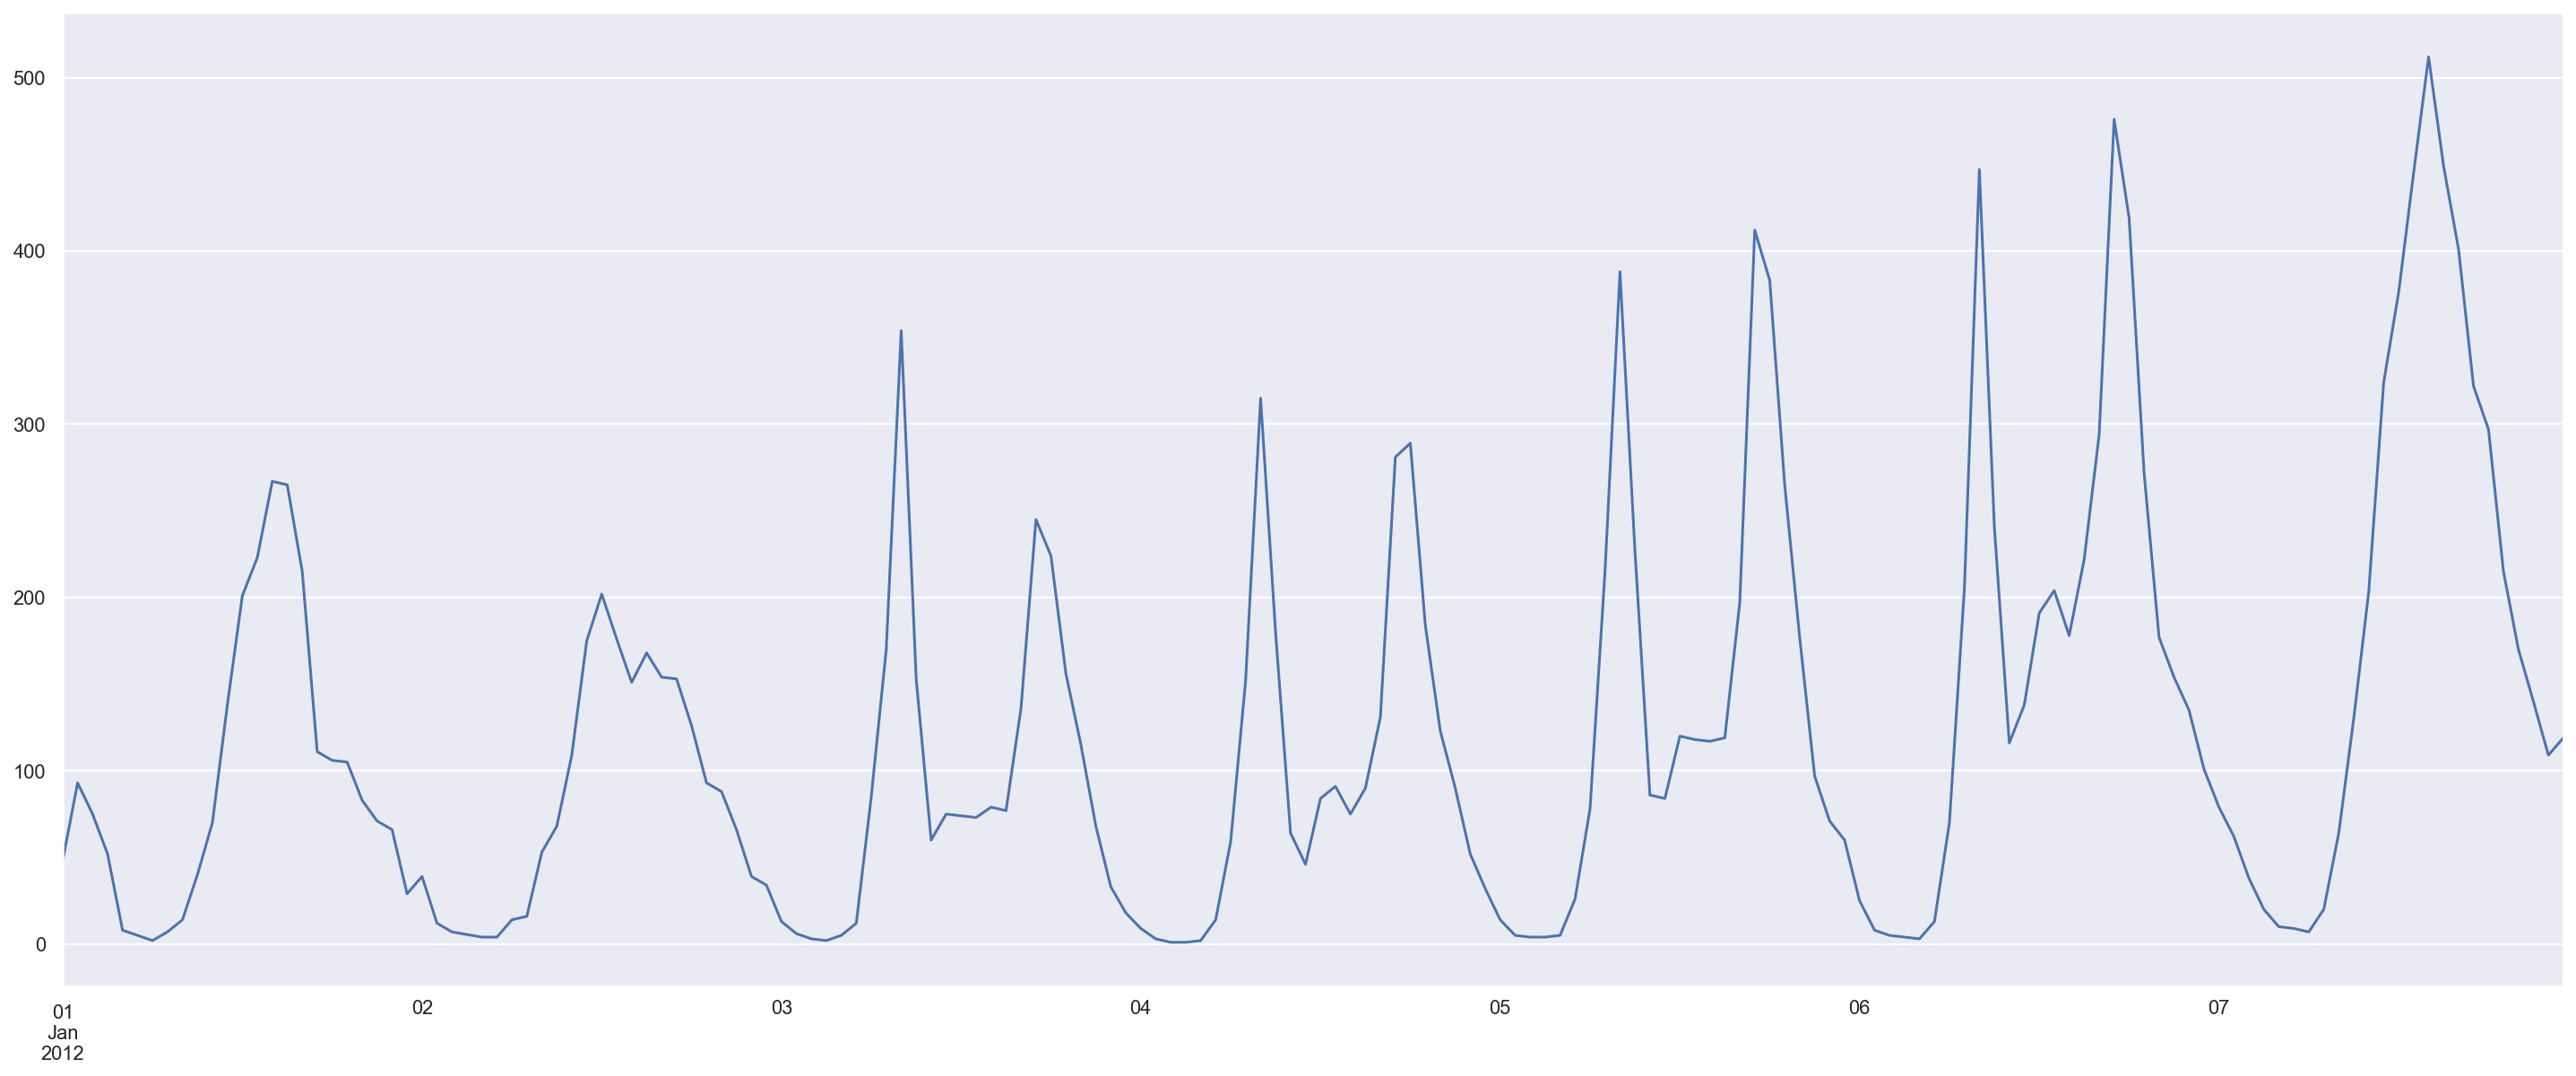

In [20]:
df["cnt"].loc["2012-01-01":"2012-01-07"].plot();

Note that the week starts on a Sunday, during the weekend. We can clearly distinguish the commute patterns in the morning and evenings of the work days and the leisure use of the bikes on the weekends with a more spread peak demand around the middle of the days.

***NOTE***: This is a preocedure we only use for data analysis, we are going to operate with an object called _imputer_ based on knn to impute missing values in the feature engineering part.

### Split in train and dev_test set

We do not have access to test labels, so, we need to create a `development_test` set in order to have something to measure our performances on and to build a metric to make comparisons.

Since we are treating a time series problem, we need to use a time series cross validation method.
Let's define a function to calculate the score on a time series cross validation split.

In [21]:
X = train_df.drop(["registered", "casual", "cnt"], axis="columns")
y = train_df["cnt"]

test_X = train_df.iloc[:-120] # Last 120 hours (5 days)
test_y = train_df["cnt"].iloc[:-120] # Last 120 hours (5 days)

def calculate_score(model : BaseEstimator, X_train: np.ndarray, y_train: np.ndarray, scoring: str = "neg_mean_absolute_error", n_splits: int = 10) -> float:
    """Function to calculate the dev_test score of a given model.

    Parameters
    ----------
    model: BaseEstimator
        Model object of sklearn.
    X_train : np.ndarray
        Train data to be split thanks to time series cross validation split.
    y_train : np.ndarray
        Train label.
    scoring : str, optional
        score to be calculated in time series splitting. It has to be a score (more is better), by default "neg_mae".
    n_splits : int, optional
        number of batches in which the train dataset is divided, by default 10.

    Returns
    -------
    float
        The average score over n_splits validation batches.
    """
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=48, max_train_size=10000, test_size=1000)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring=scoring)

    print(f"""Results: 
            - {scoring}: {cv_results.mean()}
            - {scoring}_standard_dev: {cv_results.std()}""")
    
    return cv_results.mean()

Since the dataset is a time-ordered event log (hourly demand), we used a time-sensitive cross-validation splitter to evaluate our demand forecasting model as realistically as possible. 
We used a gap of 2 days between the train and test side of the splits. 
We also limited the training set size to make the performance of the CV folds more stable.

$1000$ test datapoints should be enough to quantify the performance of the model.
 This represents a bit less than a month and a half of contiguous test data.

In [22]:
tscv = TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10000, test_size=1000)
all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]

# We manualy inspect the first split
assert X.iloc[train_0].shape == (10000, 14), "Something went wrong in train split" 
assert X.iloc[test_0].shape == (1000, 14), "Something went wrong in test split"
X.iloc[test_0]

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
11637    11638  2012-05-05       2   1     5   2        0        6   
11638    11639  2012-05-05       2   1     5   3        0        6   
11639    11640  2012-05-05       2   1     5   4        0        6   
11640    11641  2012-05-05       2   1     5   5        0        6   
11641    11642  2012-05-05       2   1     5   6        0        6   
...        ...         ...     ...  ..   ...  ..      ...      ...   
12632    12633  2012-06-15       2   1     6  13        0        5   
12633    12634  2012-06-15       2   1     6  14        0        5   
12634    12635  2012-06-15       2   1     6  15        0        5   
12635    12636  2012-06-15       2   1     6  16        0        5   
12636    12637  2012-06-15       2   1     6  17        0        5   

       workingday  weathersit  temp   atemp   hum  windspeed  
11637           0           1  0.58  0.5455  0.88     0.0000  
11638           0           1  0.58  0.5455  0.83     0.0000  
11639           0           1  0.56  0.5303  0.88     0.1045  
11640           0           1  0.56  0.5303  0.88     0.0896  
11641           0           2  0.54  0.5152  0.94     0.0000  
...           ...         ...   ...     ...   ...        ...  
12632           1           1  0.70  0.6364  0.42     0.2537  
12633           1           1  0.72  0.6515  0.39     0.1940  
12634           1           1  0.72  0.6515  0.39     0.1940  
12635           1           1  0.72  0.6515  0.37     0.1940  
12636           1           1  0.74  0.6515  0.37     0.2836  

[1000 rows x 14 columns]

#### Categorical variables

We now introspect the distribution of the categorical variables, starting with "weathersit".

In [23]:
df["weathersit"].value_counts()

1.0    11119
2.0     4225
3.0     1453
4.0        3
Name: weathersit, dtype: int64

Since there are only 3 "heavy_rain" events, we cannot use this category to train machine learning models with cross validation. Instead, we simplify the representation by collapsing those into the "rain" category (_i.e._ category number 3).

In [24]:
X["weathersit"] = X["weathersit"].replace(to_replace=4, value=3)

As expected, the "season" variable is well balanced.

In [25]:
df["season"].value_counts()

3.0    4512
2.0    4416
1.0    4080
4.0    3792
Name: season, dtype: int64

Consider the target variable ratio.

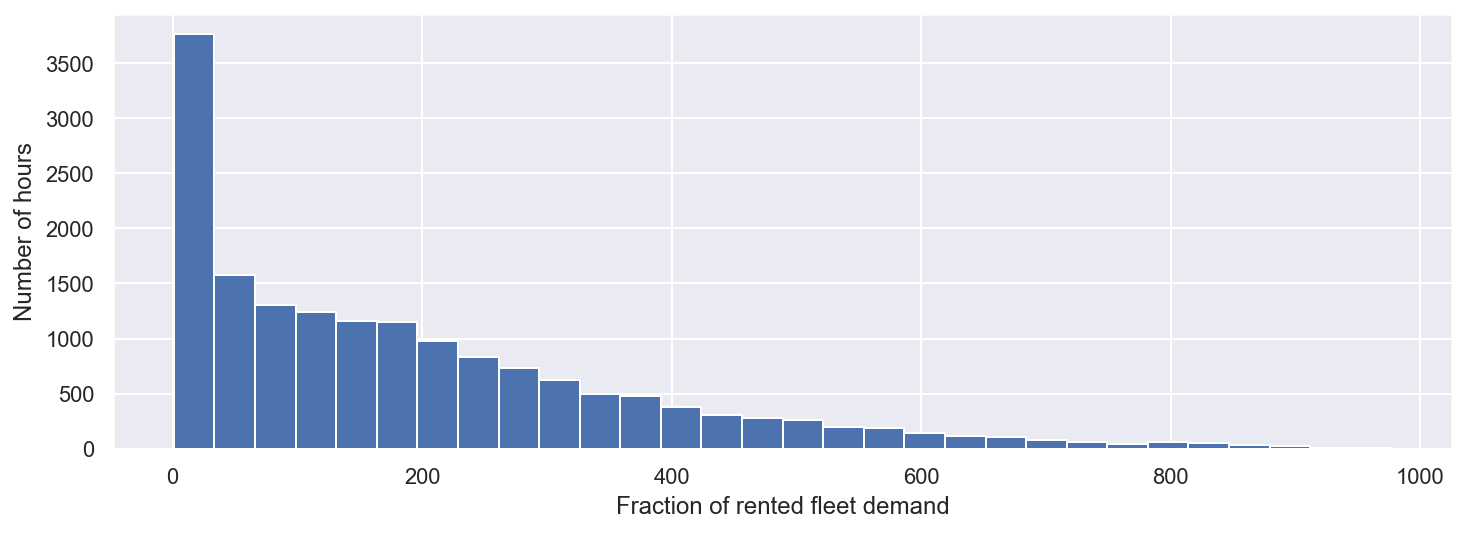

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
y.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

#### Correlations

Let's study correlation between variables and specially between features and target.

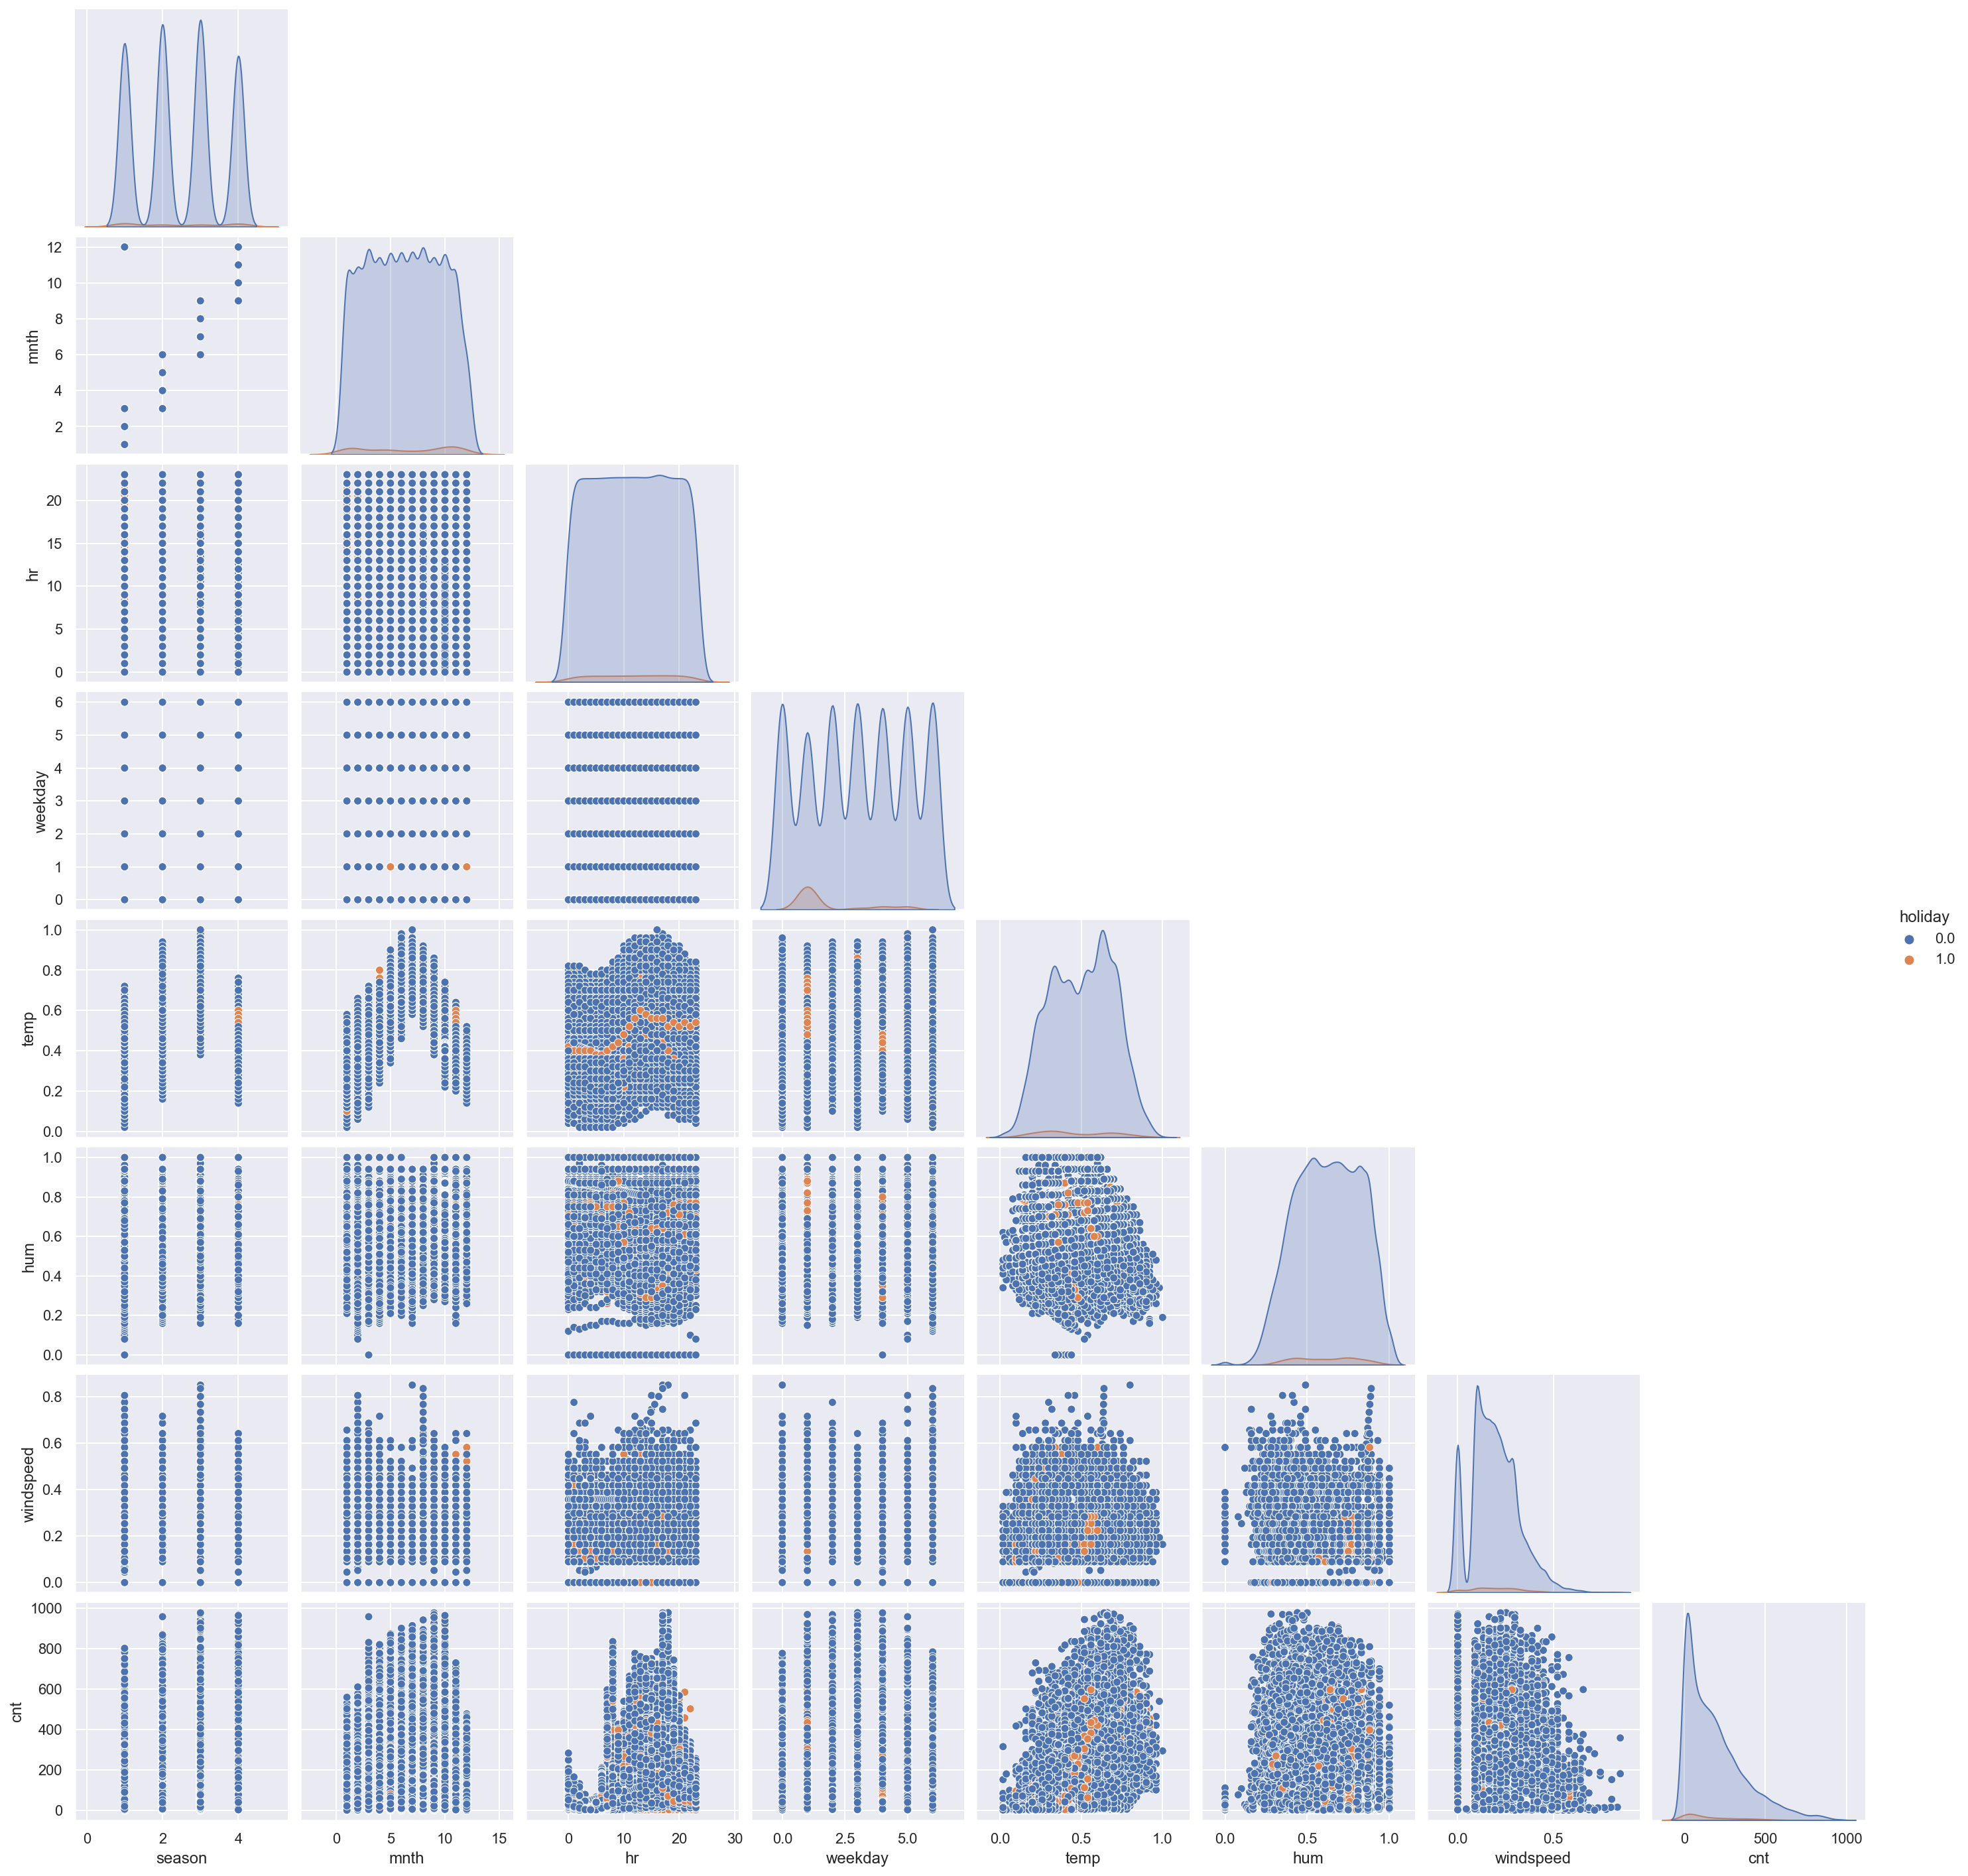

In [27]:
sns.pairplot(df, vars=['season', 'mnth', 'hr', 'weekday', 'temp', 'hum', 'windspeed', 'cnt'], hue="holiday", corner=True);

Since we are studying time series data, it is interesting to plot autocorrelations and lagged correlation functions.

We start by the target variable.

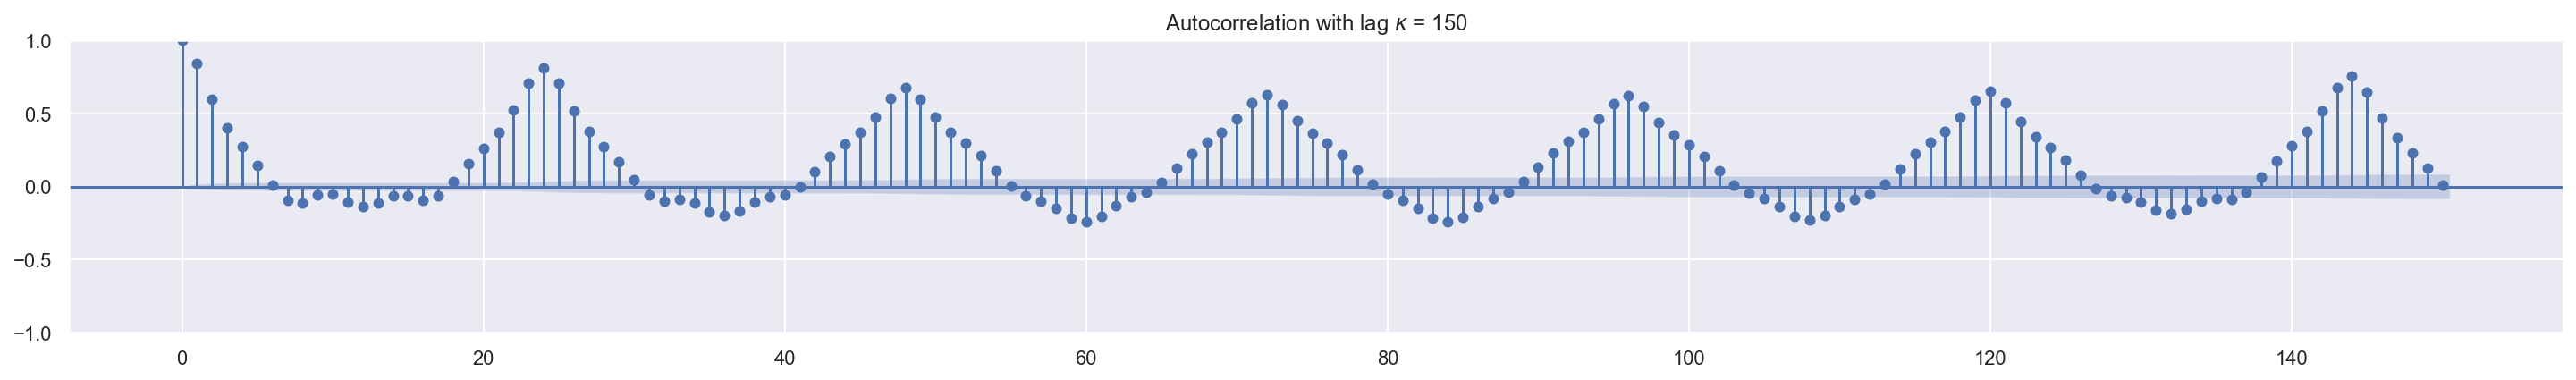

In [28]:
fig, ax = plt.subplots(figsize=(25,3))
_ = plot_acf(y, ax=ax, lags=150)
plt.title(r'Autocorrelation with lag $\kappa$ = 150');

We can see already a certain seasonality ($\sim 24$ hours). Let's see if there is another in a longer period.

We plot the rolling average of the count.

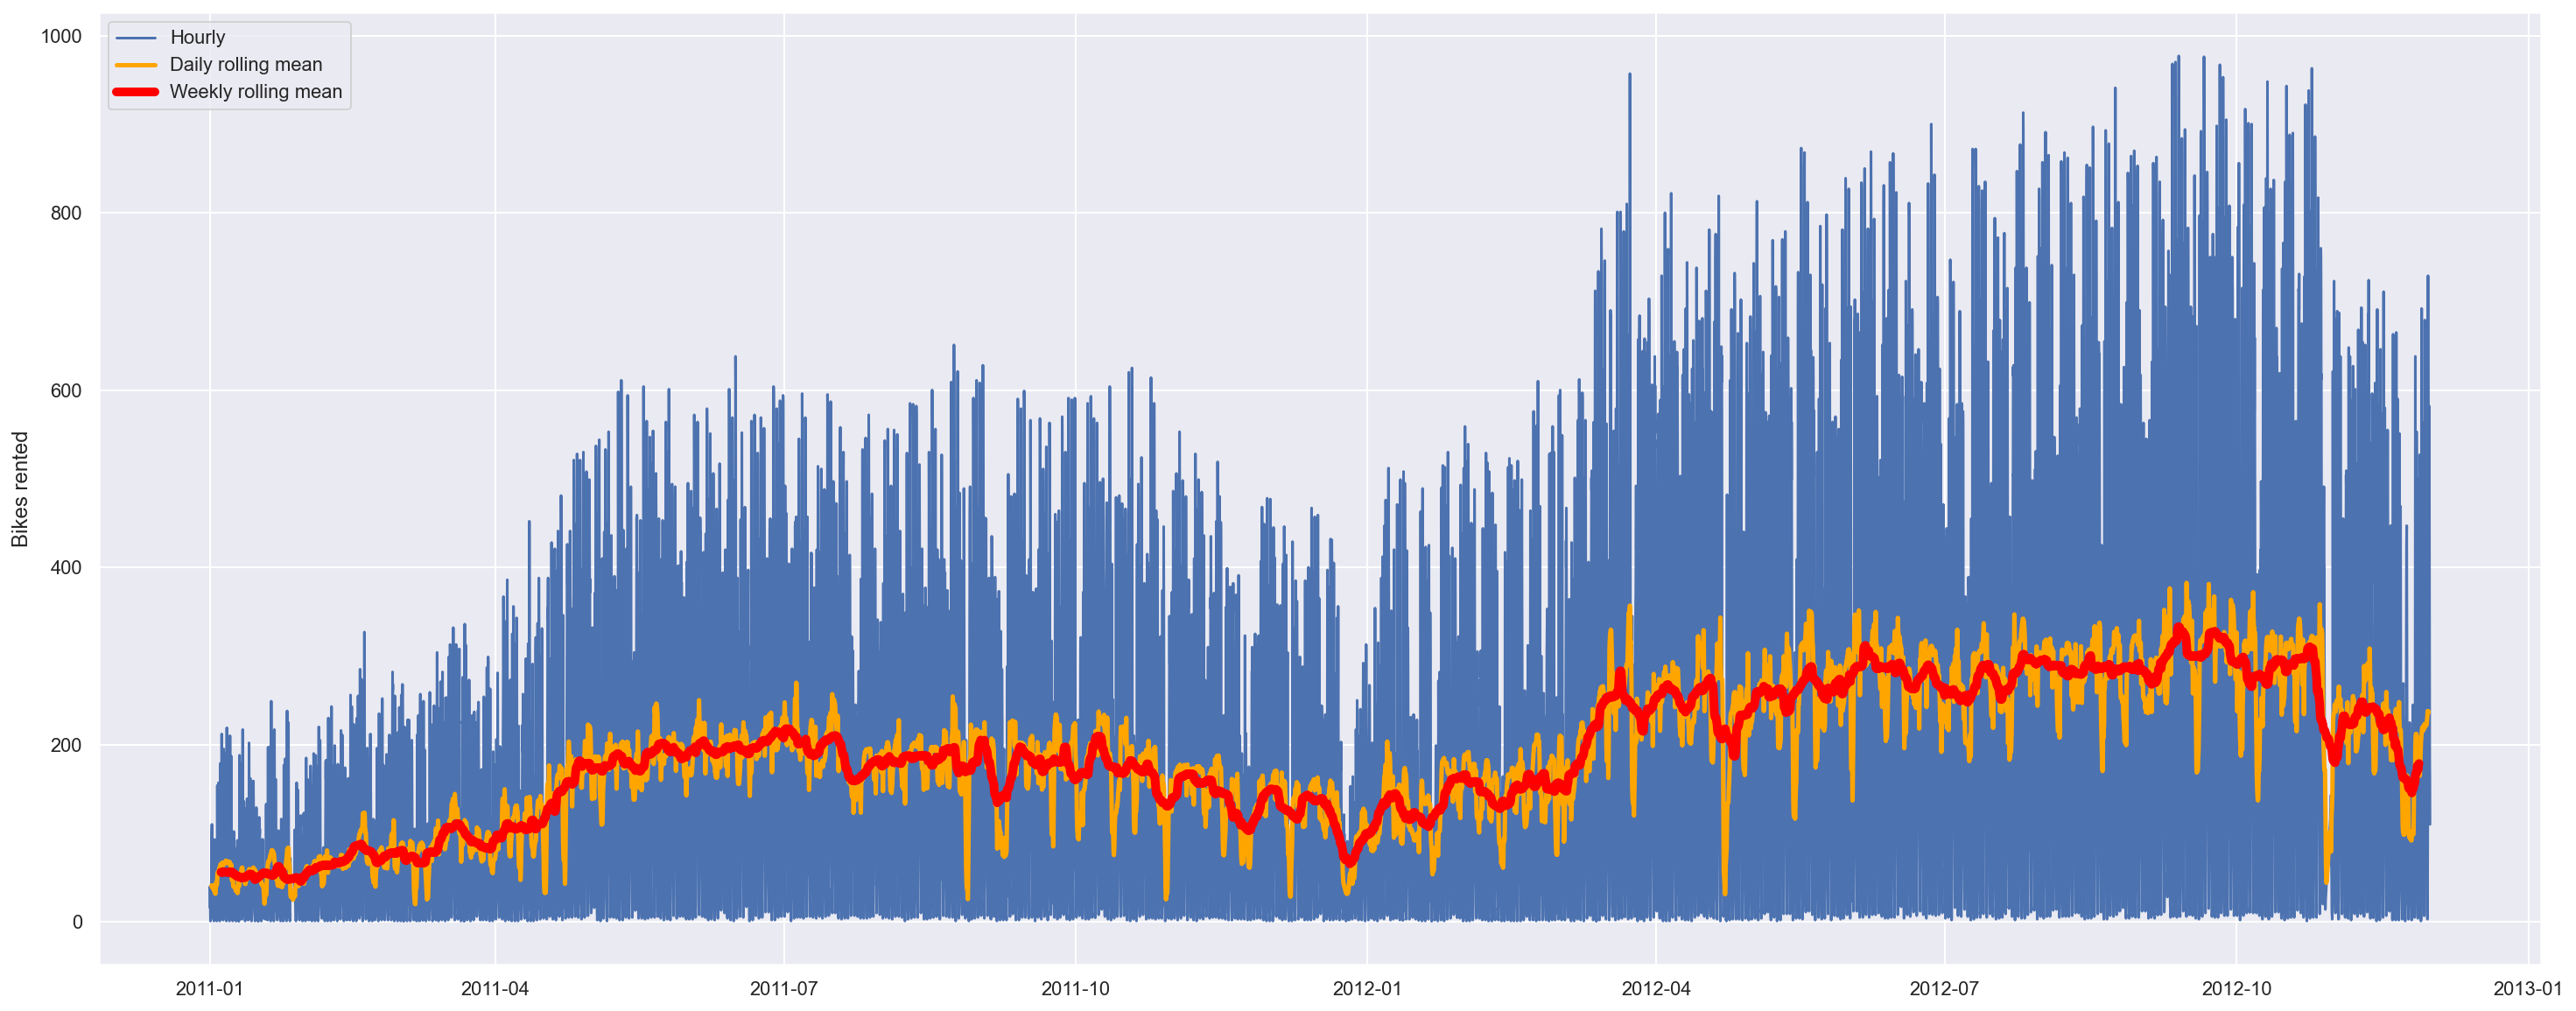

In [29]:
plt.plot(df['cnt'],
         label='Hourly')

plt.plot(df['cnt'].rolling(24, center=True).mean(),
         label='Daily rolling mean',
         color='orange',
         linewidth=2.5)

plt.plot(df['cnt'].rolling(24*7, center=True).mean(),
         label='Weekly rolling mean',
         color='red',
         linewidth=5)

plt.ylabel('Bikes rented')
plt.legend();

We can say there is an increasing trend, but nothing more than this. Or at least, there is no clear weekly or monthly seasonality.

One can be more precise and perform the seasonal decomposition of such time series. This is left as an exercise.

##### Lagged correlation

To conclude this part of the analysis, let's find if there is a feature that is particularly correlated with a lagged value of the target, and eventually determine the value of this lag.

In [30]:
def lagcorr(series1: pd.Series, series2: pd.Series, lag: int) -> float:
    """Given two pandas series, calculate the correlation of the first with the lagged version of the second by a parameter lag.

    Parameters
    ----------
    series1 : pd.Series
        One time series.
    series2 : pd.Series
        Another time series.
    lag : int
        The lag between the two series.

    Returns
    -------
    float
        The value of pearson correlation between the first series and the lagged version of the second one.
    """
    return series1.corr(series2.shift(lag))

def find_max_corrlag(series1: pd.Series, series2: pd.Series) -> None:
    """Given two pandas series, print the max correlation lag and the corresponding score.

    Parameters
    ----------
    series1 : pd.Series
        One time series.
    series2 : pd.Series
        Another time series.
    """
    corrs = []
    for lag in range(50):
        corrs.append(lagcorr(series1, series2, lag))

    print(f"Max correlation lag: {np.argmax(corrs)} hours")
    print(f"Max correlation score: {np.max(corrs)}")

In [31]:
find_max_corrlag(df["temp"], df["cnt"])

Max correlation lag: 1 hours
Max correlation score: 0.41507919518311587


The first interesting result: temperature and rented bikes are correlated better with one hour-lag. 

> If today is hot, one will probably rent a bike to go to work.

Let's see other features.

In [32]:
corrs = []
for lag in range(50):
  corrs.append(lagcorr(df["windspeed"], df["cnt"], lag))

print(f"Max correlation lag: {np.argmax(corrs)} hours")
print(f"Max correlation score: {np.max(corrs)}")

Max correlation lag: 48 hours
Max correlation score: 0.1190788505045052


Nothing very clear.

Let's move to the seasonality analysis.

### Time Series Decomposition

We want to analyse this time series and study its components to see whether a _General Additive Model_ like prophet can work well.

**NOTE**: A _General Additive Model_ is an autoregressive model that can be written as follows:

$$y_t = \alpha_1 f_1(y_{t-1}) + \ldots +\alpha_k f_k(y_{t-k})\, ,$$

where in general the $f$'s are non-linear functions.

We already encoded the values into a dataframe or a series having time index, so let's proceed.

In [33]:
df.head(3)

instant  season   yr  mnth   hr  holiday  weekday  \
2011-01-01 00:00:00      1.0     1.0  0.0   1.0  0.0      0.0      6.0   
2011-01-01 01:00:00      2.0     1.0  0.0   1.0  1.0      0.0      6.0   
2011-01-01 02:00:00      3.0     1.0  0.0   1.0  2.0      0.0      6.0   

                     workingday  weathersit  temp   atemp   hum  windspeed  \
2011-01-01 00:00:00         0.0         1.0  0.24  0.2879  0.81        0.0   
2011-01-01 01:00:00         0.0         1.0  0.22  0.2727  0.80        0.0   
2011-01-01 02:00:00         0.0         1.0  0.22  0.2727  0.80        0.0   

                     casual  registered   cnt  
2011-01-01 00:00:00     3.0        13.0  16.0  
2011-01-01 01:00:00     8.0        32.0  40.0  
2011-01-01 02:00:00     5.0        27.0  32.0

Let's proceed to the **decomposition**.

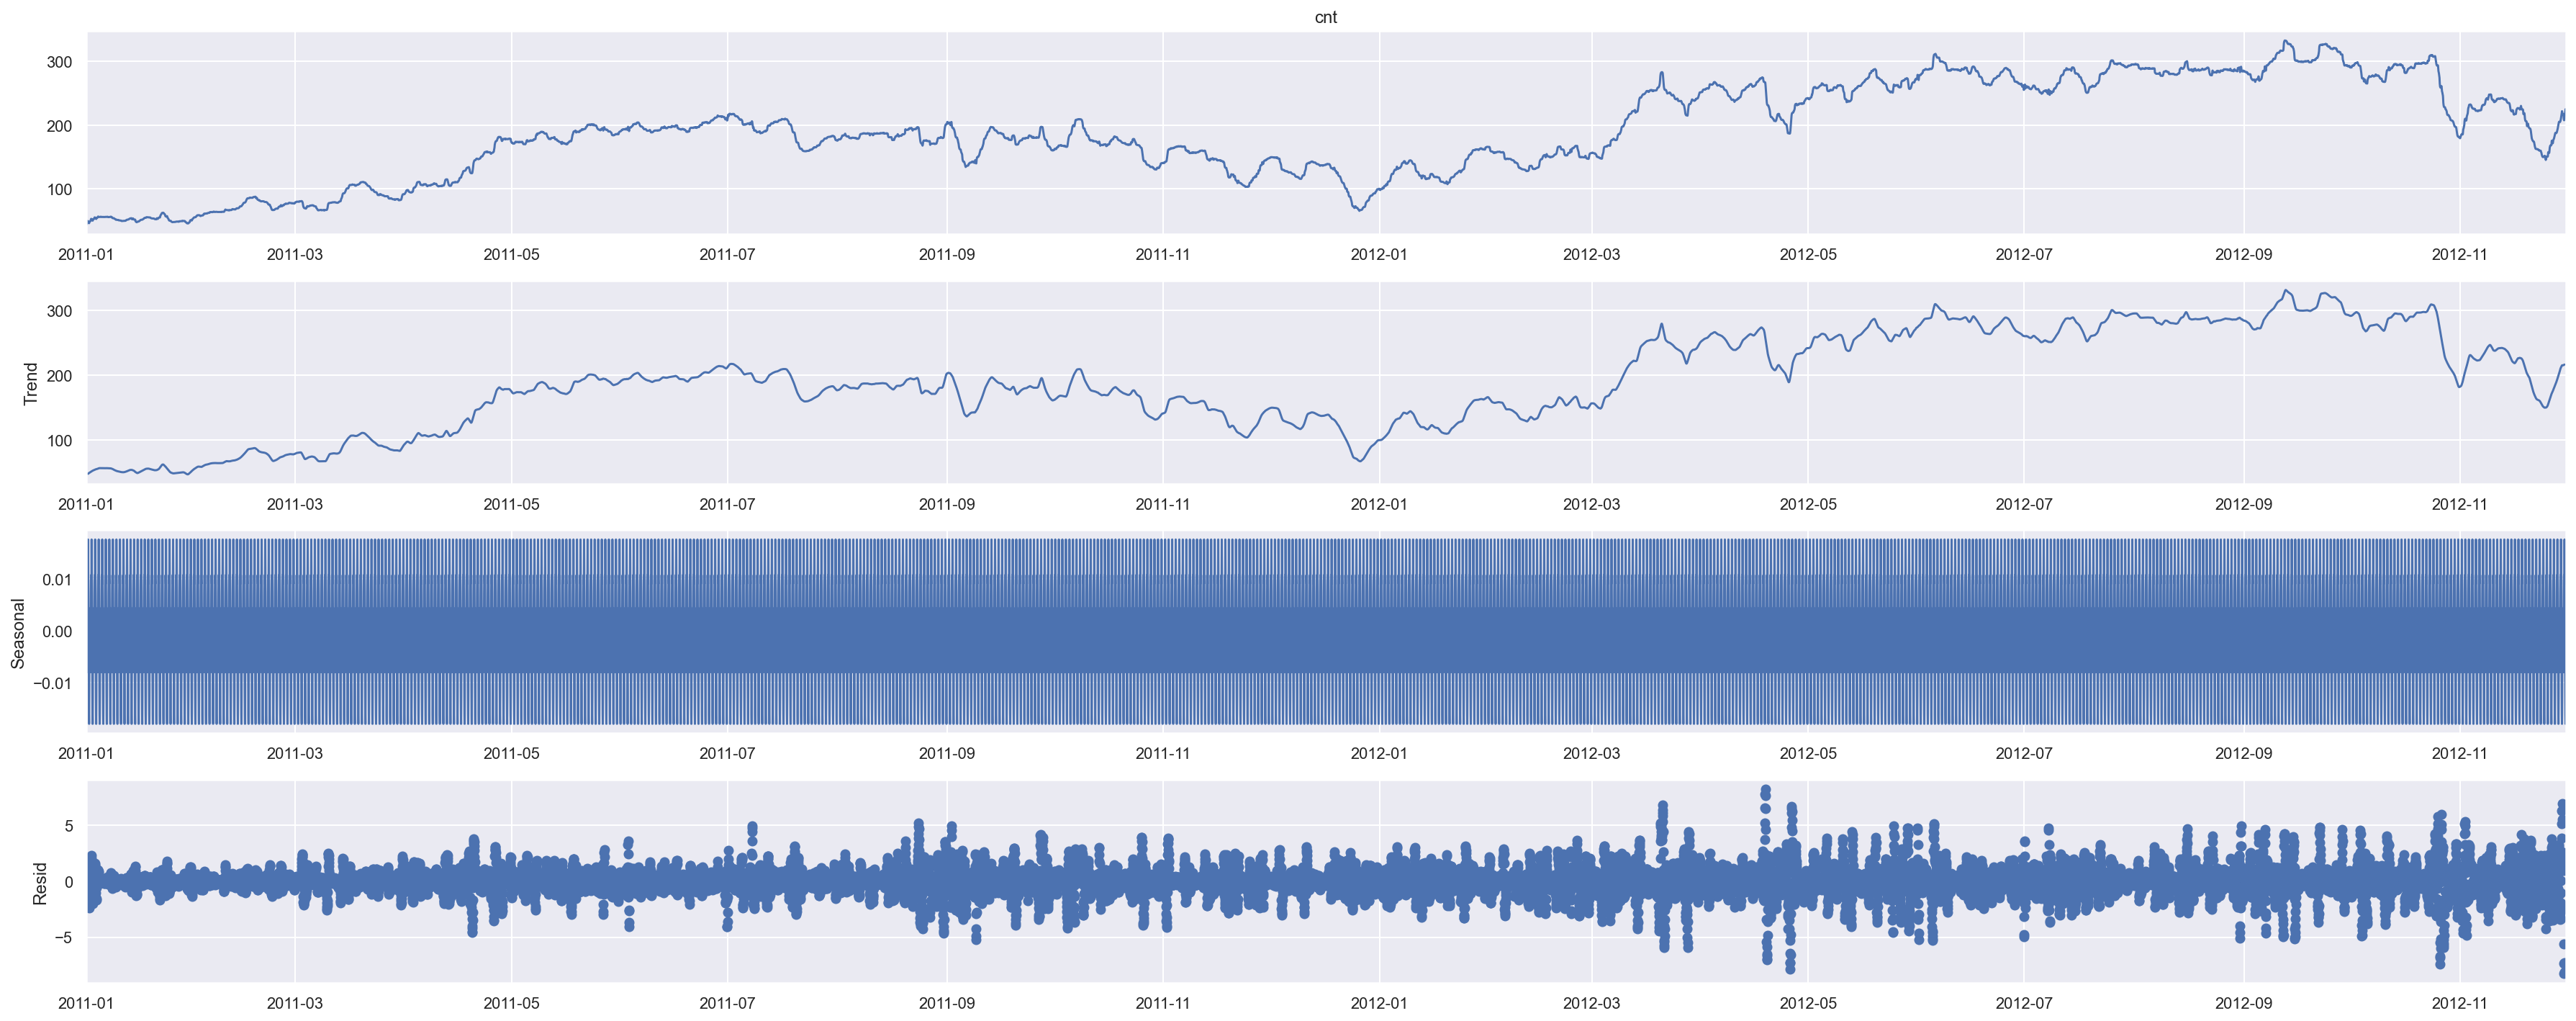

In [34]:
# Let's decompose the time series in components
decomposition = seasonal_decompose(df['cnt'].rolling(24*7, center=True, min_periods=1).mean()) # monthly rolling to have a better visualisation
plot = decomposition.plot() # avoids repeated plots

Seasonality is really confused, of course there is a daily seasonality, as one can see by plotting the following.

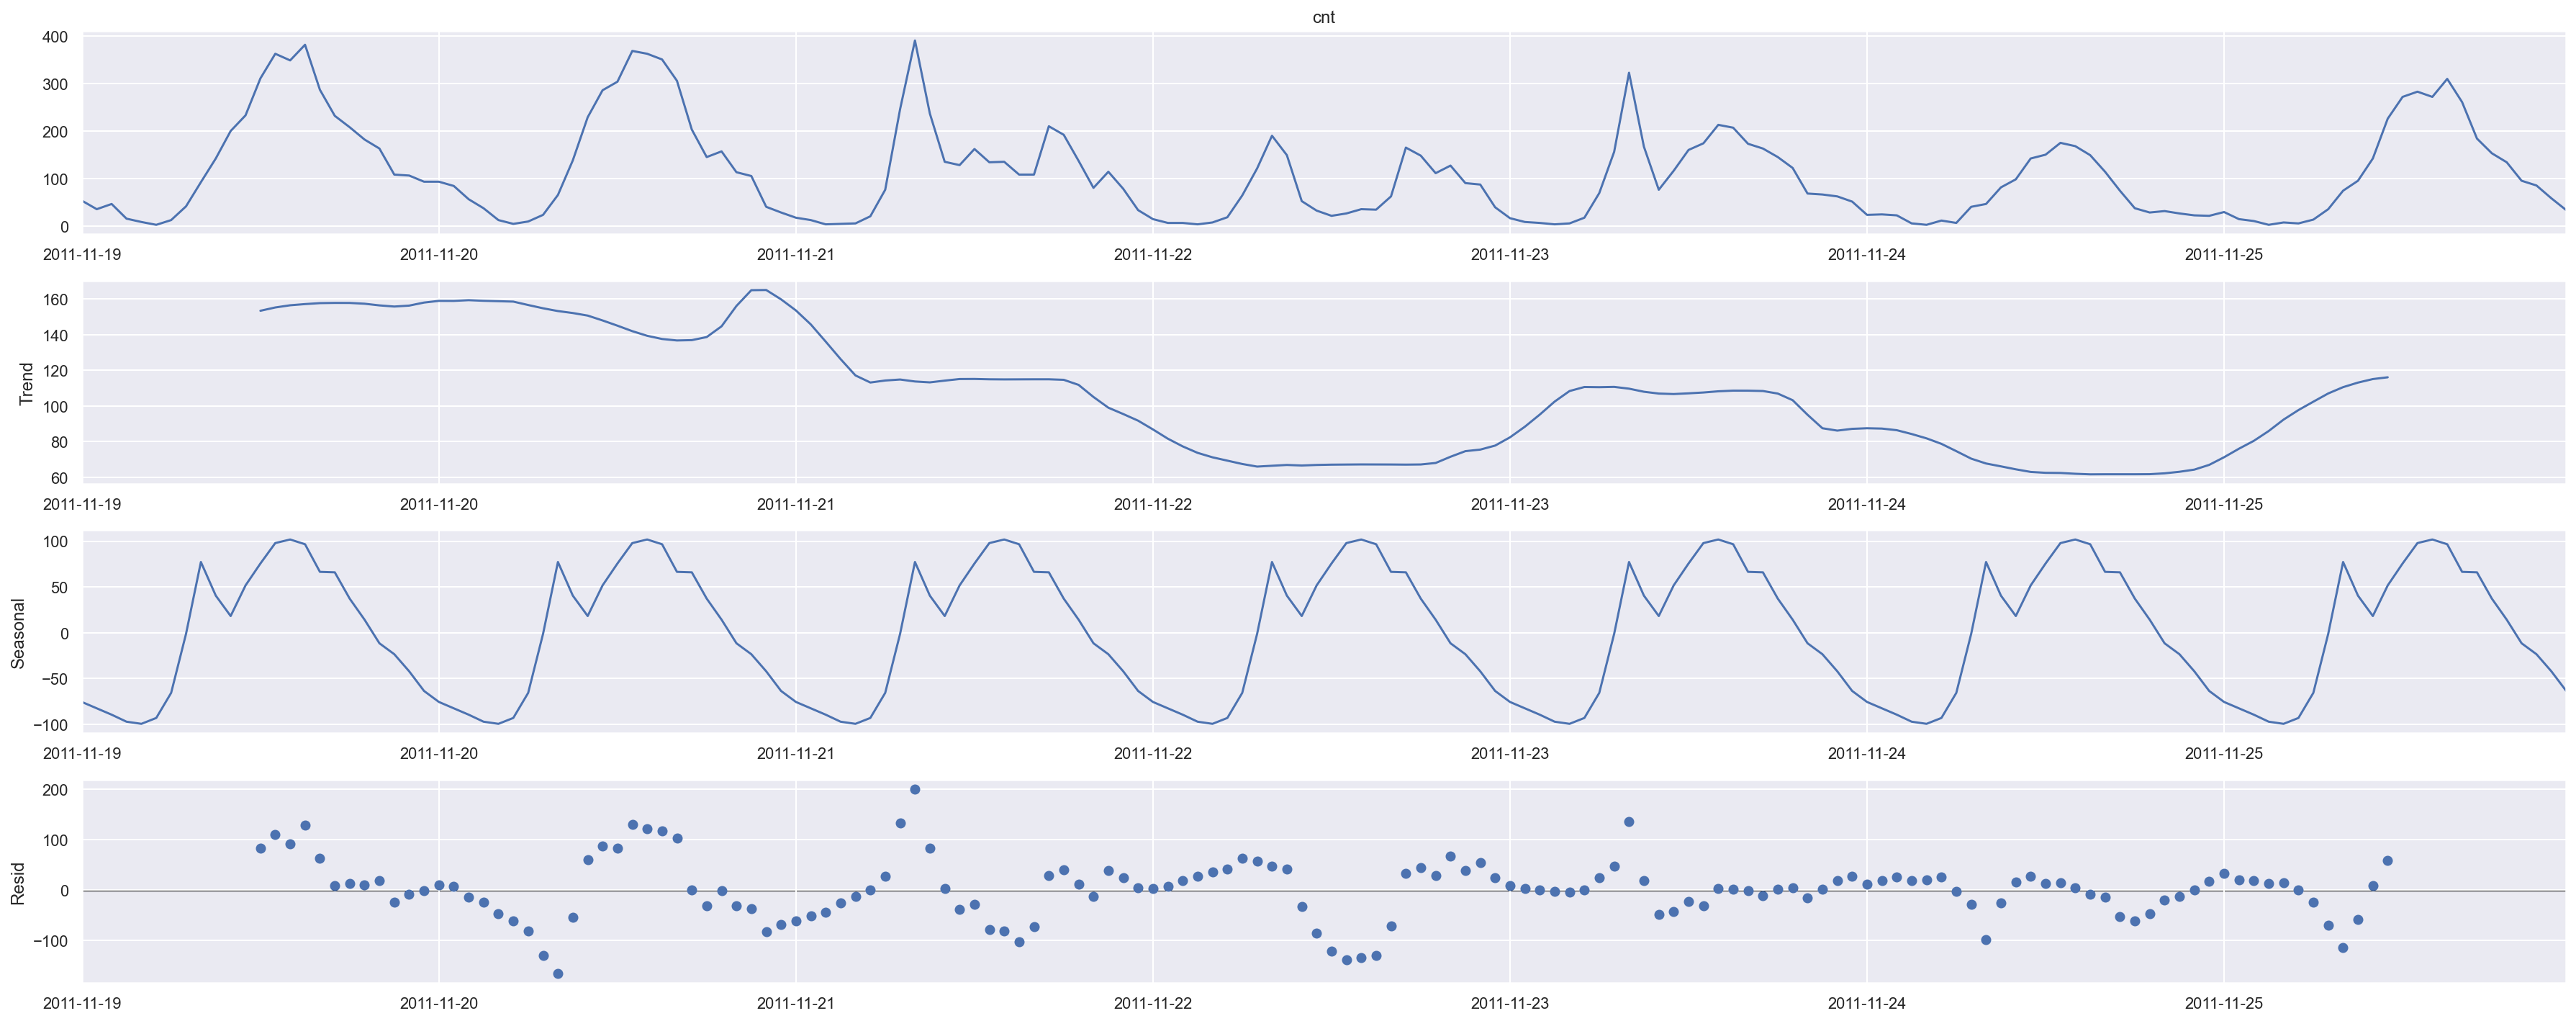

In [35]:
# Let's decompose the time series in components
week = (24*7)
k = 46
decomposition = seasonal_decompose(df['cnt'].iloc[k*week:(k+1)*week]) # just one week of data to show daily seasonality
plot = decomposition.plot() # avoids repeated plots

However, there is no clear indication that on the general there is a precise seasonality, this is the reason why a model based on prophet would require a lot of fine tuning to perform well.

It is now time to move on and equipped with such knowledge coming from the data analysis, put our discoveries in a feature engineering, _i.e._ a preprocessing pipeline.

## Feature Engineering

This section aim is to perform some operations and modify features in order to get our model to learn more and more effectively.

### Imputing

We have already seen how there is the need to impute missing values using a different strategy for different columns. 
This is precisely the role of the imputer inserted in a column transformer.

Recall that the dataframe does not have formally any missing value, in order to make them explicitly we need to resample them. This can be done with a pandas operation.
However, we want our pipeline to read numpy arrays, hence let's create a function that will be the input of a `FunctionTransformer` object in scikit-learn. 
Such an object will be inserted into column transformers and pipelines.

In [36]:
def resample_array(x: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
    """Function resampling the input in order to make nan values appear explicitly.

    Parameters
    ----------
    x : Union[pd.DataFrame, np.ndarray]
        Array or dataframe containing a column "dteday" and a column "hr" at positions 1 and 5.
        The function also drops the "dteday" column.

    Returns
    -------
    np.ndarray
        The resampled array with eventually np.nan values.
    """
    try: # dataframe case
        x['dteday'] = pd.to_datetime(x.dteday, format='%Y-%m-%d')
        x['hr2'] = x.hr.astype(str).str.zfill(2) # hours have 2-digits.

        x.index = pd.to_datetime(x['dteday'].astype(str) + ' ' + x['hr2'], format='%Y-%m-%d %H')
        x = x.asfreq(freq="h")
        x = x.drop(["instant", "dteday", "hr2"], axis=1) # Drop useless and auxiliary column
        return x.values 

    except AttributeError: # array case
        x_df = pd.DataFrame(x)
        x_df.iloc[:,1] = pd.to_datetime(x_df.iloc[:,1], format='%Y-%m-%d')
        x_df['hr2'] = x_df.iloc[:,5].astype(str).str.zfill(2) # hours have 2-digits.

        x_df.index = pd.to_datetime(x_df.iloc[:,1].astype(str) + ' ' + x_df['hr2'], format='%Y-%m-%d %H')
        x_df = x_df.asfreq(freq="h")
        x_df = x_df.iloc[:, 2:-1] # Drop the first two and the last column
        return x_df.values 

resample_transformer = FunctionTransformer(resample_array)

In [37]:
assert train_df.shape == (16637, 17), "You are passing the wrong dataframe"
assert resample_transformer.fit_transform(train_df.values).shape == (16800, 15), "Something went wrong"

print("\033[92m All tests passed!")

 All tests passed!


### Scaling and Encoding

We procede then to scale numerical variables and encode categorical ones.

#### StandardScaler

Numerical variables do not present a relavant quantity of outliers, (look at the pairplot above) so we choose the `StandardScaler` in order to not "compress" our values too much.

#### OneHot and Ordinal Encoding

We split categorical variables in two sets: 

1. Binary variables
2. Non-binary variables

For the first category, we can use one-hot encoding as we map "Yes" into $1$ and "No" into $0$.
On the other hand, the non-binary variables are often indicating an order, hence the ordinal encoding seems to be more approriate.

#### Target variable

In principle there is no need to scale target variables. 
However, since we have not make any choice about the algorithm yet, we decide to report the numerical value of the count to the same scale of the other features, this will not increase the model score, but it will help us making the training phase a bit faster. 
Furthermore, scaling in this case helps the interpretability: rescaling the target variable (number of hourly bike rentals) helps to predict a relative demand so that the _mean absolute error_ is more easily interpreted as a fraction of the maximum demand.

### Important note: data leakage

As one can notice the target variable is always the sum of registered and casual users. Indeed these are an example of variables we do not know in advance: hence we need to remove them.

> We must be sure that we only provide our model data that are available at prediction time.

### Add features (lagged)

Here we need to come up with lagged features from existing ones in order to improve on the training process of our dataset.

As before, we are going to create such fields thanks to `FunctionTransformer` in scikit-learn and insert such an object into column transformers and pipelines.

In [38]:
x = df.hum
shifted_x = np.zeros(x.shape, dtype=float)

In [39]:
def get_lagged_features(x: Union[pd.Series, np.ndarray], lags: int=24, gap: int=48) -> np.ndarray:
    """Function that returns an array containing the corresponding lagged feature to the passed inputs.

    Parameters
    ----------
    x : Union[pd.Series, np.ndarray]
        Pandas series or numpy array containing the feature to be lagged.
        shape: (n_examples, 1)
    lag: int
        The lag interval to be taken into account.
        default: 24 (one day)
    gap: int
        The gap between the first lagged variable and the forecast time.
        default: 48 (2 days)

    Returns
    -------
    np.ndarray
        array containing the lagged columns corresponding to the one passed as input.
        shape: (n_examples, lags)
    """
    try:
        x = x.values
    except AttributeError:
        pass
    
    shifts = []
    for i, k in enumerate(range(gap+1, gap+lags+1)):
        shifted_x = np.zeros(x.shape, dtype=float)
        shifted_x[i:] = np.roll(x, shift=k)[i:]
        shifts.append(shifted_x)
    
    # shifts.insert(0, x) # prepend x to the list (unwanted)
    x_shifts = np.column_stack(shifts)
    return x_shifts


# Insert in a scikit-learn object
lag_tranformer = FunctionTransformer(get_lagged_features)

In [40]:
assert df.shape == (16800, 16), "You are passing the wrong dataframe"
assert lag_tranformer.fit_transform(df.hum).shape == (16800, 24), "Shapes are wrong"
assert (lag_tranformer.fit_transform(df.hum)[:23][:, -1] == np.zeros((23,))).all(), "Shifts are wrong"

print("\033[92m All tests passed!")

 All tests passed!


As last step we need to remove all the NaN's values coming from the lag procedure, this is easily done by an indexing slice.

In [41]:
def remove_lag_nan(x: Union[pd.Series, np.ndarray], lags: int=24) -> np.ndarray:
    """Function that returns an array containing with dropped nan's due to lags.

    Parameters
    ----------
    x : Union[pd.Series, np.ndarray]
        Pandas series or numpy array containing the feature to be lagged.
        shape: (n_examples, lags)
    lag: int
        The lag interval to be taken into account.
        default: 24 (one day)
    gap: int
        The gap between the first lagged variable and the forecast time.
        default: 48 (2 days)

    Returns
    -------
    np.ndarray
        array containing the lagged columns corresponding to the one passed as input.
        shape: (n_examples-lags, lags)
    """
    
    try: # Pandas Series case
        return x.iloc[lags:]
    except AttributeError: # array case
        return x[lags:]


# Insert in a scikit-learn object
remove_lag_nan_tranformer = FunctionTransformer(remove_lag_nan)

#### Identity Encoder

It would be useful to have a transformer that does not do anything: an _identity matrix_ for my feature.
There is nothing like this in sklearn, however we can define it.

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array

__Note__: This could also be achieved by a simple `FunctionTransformer` as

```python
identity_transformer = FunctionTransformer(lambda x: x)
```

Here, we defined as a new object for the sake of diversity in approach.

---

### Pipeline composition

We are ready to compose the preprocessing pipeline to put all of this together.

We proceed as follows:

- Create a baseline pipeline with no preprocessing steps but the necessary ones (namely encodings) with a linear regression model giving a baseline score.
- Create a column transformer collecting all the feature engineering procedures (function transformers, encondings, scalers, etc.)
- Create a pipeline encapsulating such a column transformer.

#### Baseline pipe

As said, we propose a baseline pipe in order to have a "score to beat".

First of all, we print the columns and their indices as we want to operate with numpy arrays.


In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     16637 non-null  int64  
 1   dteday      16637 non-null  object 
 2   season      16637 non-null  int64  
 3   yr          16637 non-null  int64  
 4   mnth        16637 non-null  int64  
 5   hr          16637 non-null  int64  
 6   holiday     16637 non-null  int64  
 7   weekday     16637 non-null  int64  
 8   workingday  16637 non-null  int64  
 9   weathersit  16637 non-null  int64  
 10  temp        16637 non-null  float64
 11  atemp       16637 non-null  float64
 12  hum         16637 non-null  float64
 13  windspeed   16637 non-null  float64
 14  casual      16637 non-null  int64  
 15  registered  16637 non-null  int64  
 16  cnt         16637 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.2+ MB


Then we built the column transformer. 

Note that the order of columns and the order of tuples is important. 
The first tuple will correspond to the first column(s) of the output array.

It is also noteworthy that we have chosen to drop the untouched columns (this is the reason why we defined the `IdentityTransformer` above), hence the column `0`, namely the instant ID or the `dteday` will not be in the output. On the other hand there are columns we do not want to rescale or encode but we want them to pass. This is the necessity behind the `IdentityTransformer`, rather than the argument "passthrough" of the `ColumnTransformer`.

In [44]:
# Baseline pipe

knn_imputer = KNNImputer(n_neighbors=2)

preprocessing_base_ct = ColumnTransformer(transformers=[
                                ("ord_seas_year_month_hr", IdentityTransformer(), slice(0,4)),
                                ("do_nothing", IdentityTransformer(), slice(4, 12)),
                                ])

preprocessing_base = Pipeline(steps=[
                                    ("resample", resample_transformer), # This drops some columns
                                    ("impute", knn_imputer),
                                    ("scale_and_encode", preprocessing_base_ct),
])

Now the main difficult is the following one. We are modifying the number of rows, hence our target variable is affected by these transformations.
In order to have the correct target value, we need to use the `preprocesing_base` pipeline and extract the right column.

Consider that scikit-learn pipelines pass the $y$ variable untouched.

In [45]:
target_steps = preprocessing_base.steps[:-1] 

target_pipe = Pipeline(steps=target_steps)
train_X = preprocessing_base.fit_transform(train_df)[:,:-1]
train_y = target_pipe.fit_transform(train_df)[:,-1] # cnt is the last column

#assert train_y.shape == (16776,), "something went wrong"
assert train_y.shape[0] == train_X.shape[0], "something went wrong"

print("\033[92m All tests passed!")

 All tests passed!


## Modeling

Finally, we are ready to work on models.
As in the [Junior Woodchucks Guidebook](https://it.wikipedia.org/wiki/Manuale_delle_Giovani_Marmotte), we have defined first a baseline model.

<p align="center">
    <img src="https://cdn.custom-cursor.com/packs/3242/ducktales-huey-duck-and--junior-woodchuck-guidebook-pack.png">
</p>

### Baseline model evaluation

Now that we have a model working and running, let's have a look at its performances.

#### Regression metrics

We have chosen the `neg_mean_absolute error`, however it is nice to print some other metrics.

In [46]:
alphas = np.logspace(0.1, 4, 20)

base_pipe = Pipeline(steps=[("preprocessing", preprocessing_base), ("model", RidgeCV(alphas=alphas))])

base_pipe.fit(train_df, train_y)

base_score = calculate_score(model=base_pipe.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
base_score_r2 = calculate_score(model=base_pipe.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
base_score_mape = calculate_score(model=base_pipe.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
base_score_mse = calculate_score(model=base_pipe.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -122.16413241234288
            - neg_mean_absolute_error_standard_dev: 31.062497174051657
Results: 
            - r2: 0.27009945745535985
            - r2_standard_dev: 0.05031348728868188
Results: 
            - neg_mean_absolute_percentage_error: -3.861481029550494
            - neg_mean_absolute_percentage_error_standard_dev: 0.7638020416364334
Results: 
            - neg_mean_squared_error: -26146.093885454262
            - neg_mean_squared_error_standard_dev: 10965.71773881674


We visualise base model predictions by zooming on the last $120$ hours ($5$ days) of the dev_test set to get some qualitative insights.

In [47]:
base_linear_predictions = base_pipe.predict(test_X)

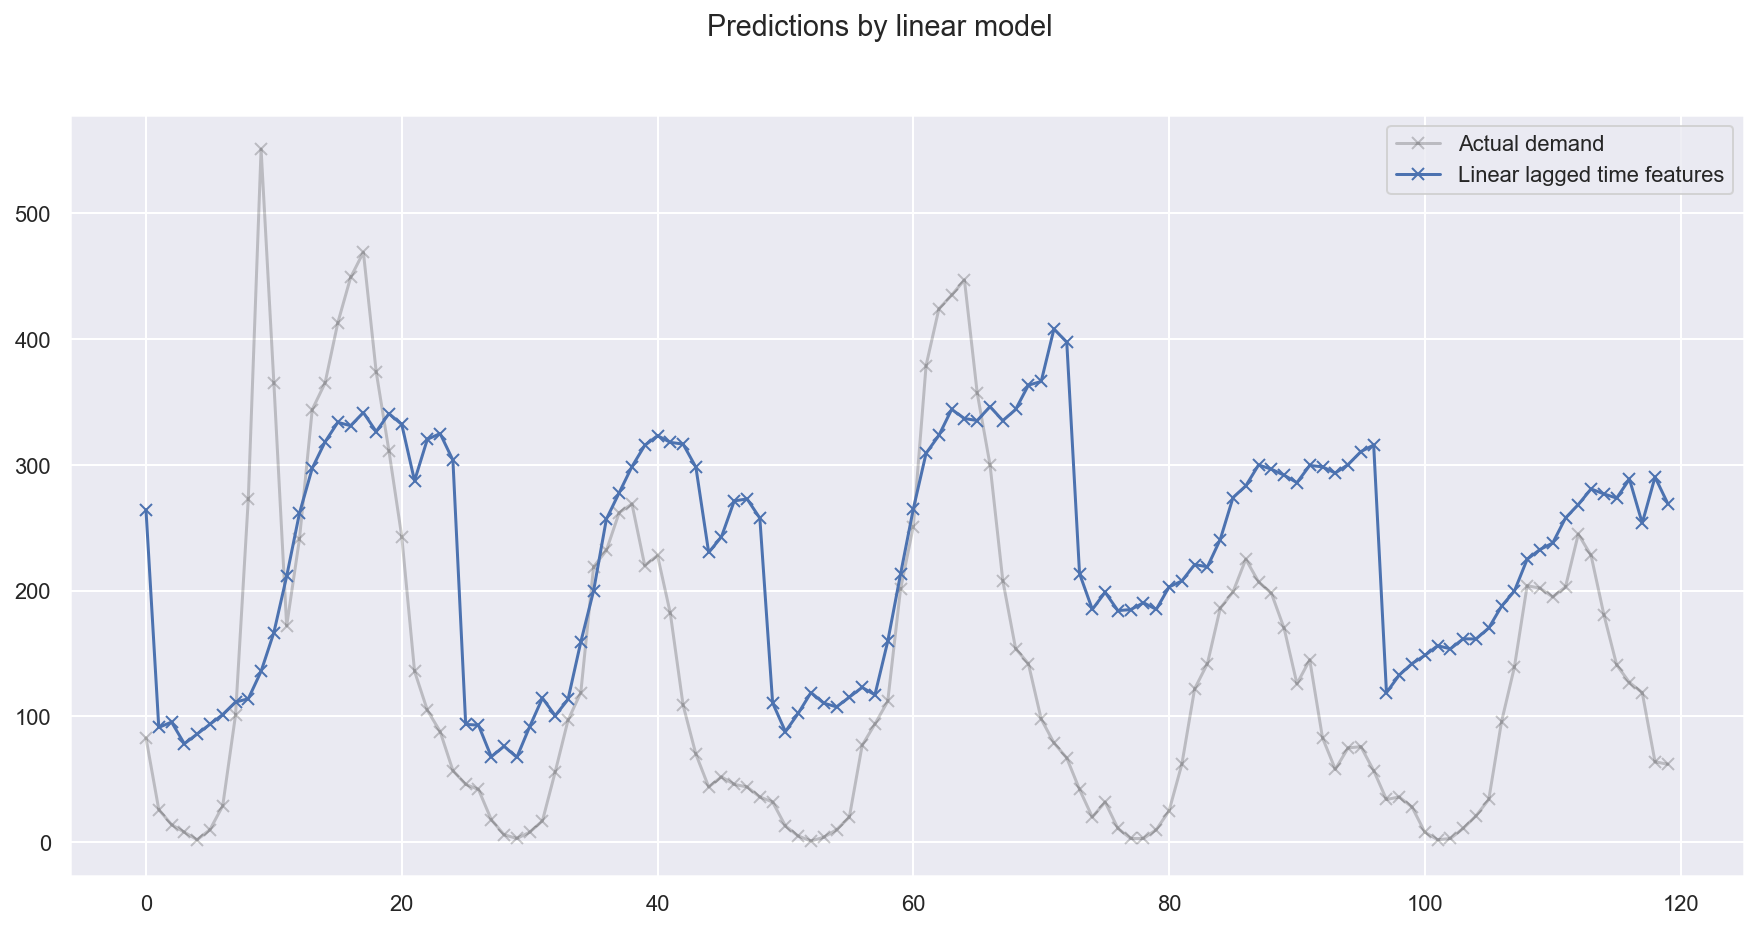

In [48]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by linear model")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    base_linear_predictions[last_hours],
    "x-",
    label="Linear model",
)
_ = ax.legend()

### Periodic encoding features

We can see there is a seasonality in our model, hence we want to ccaputer such seasonality by defining a new encoding for the hour variable, we want the way to encode our variable to reflece it. We can achieve such result by some periodic functions, like $\sin$ and $\cos$.

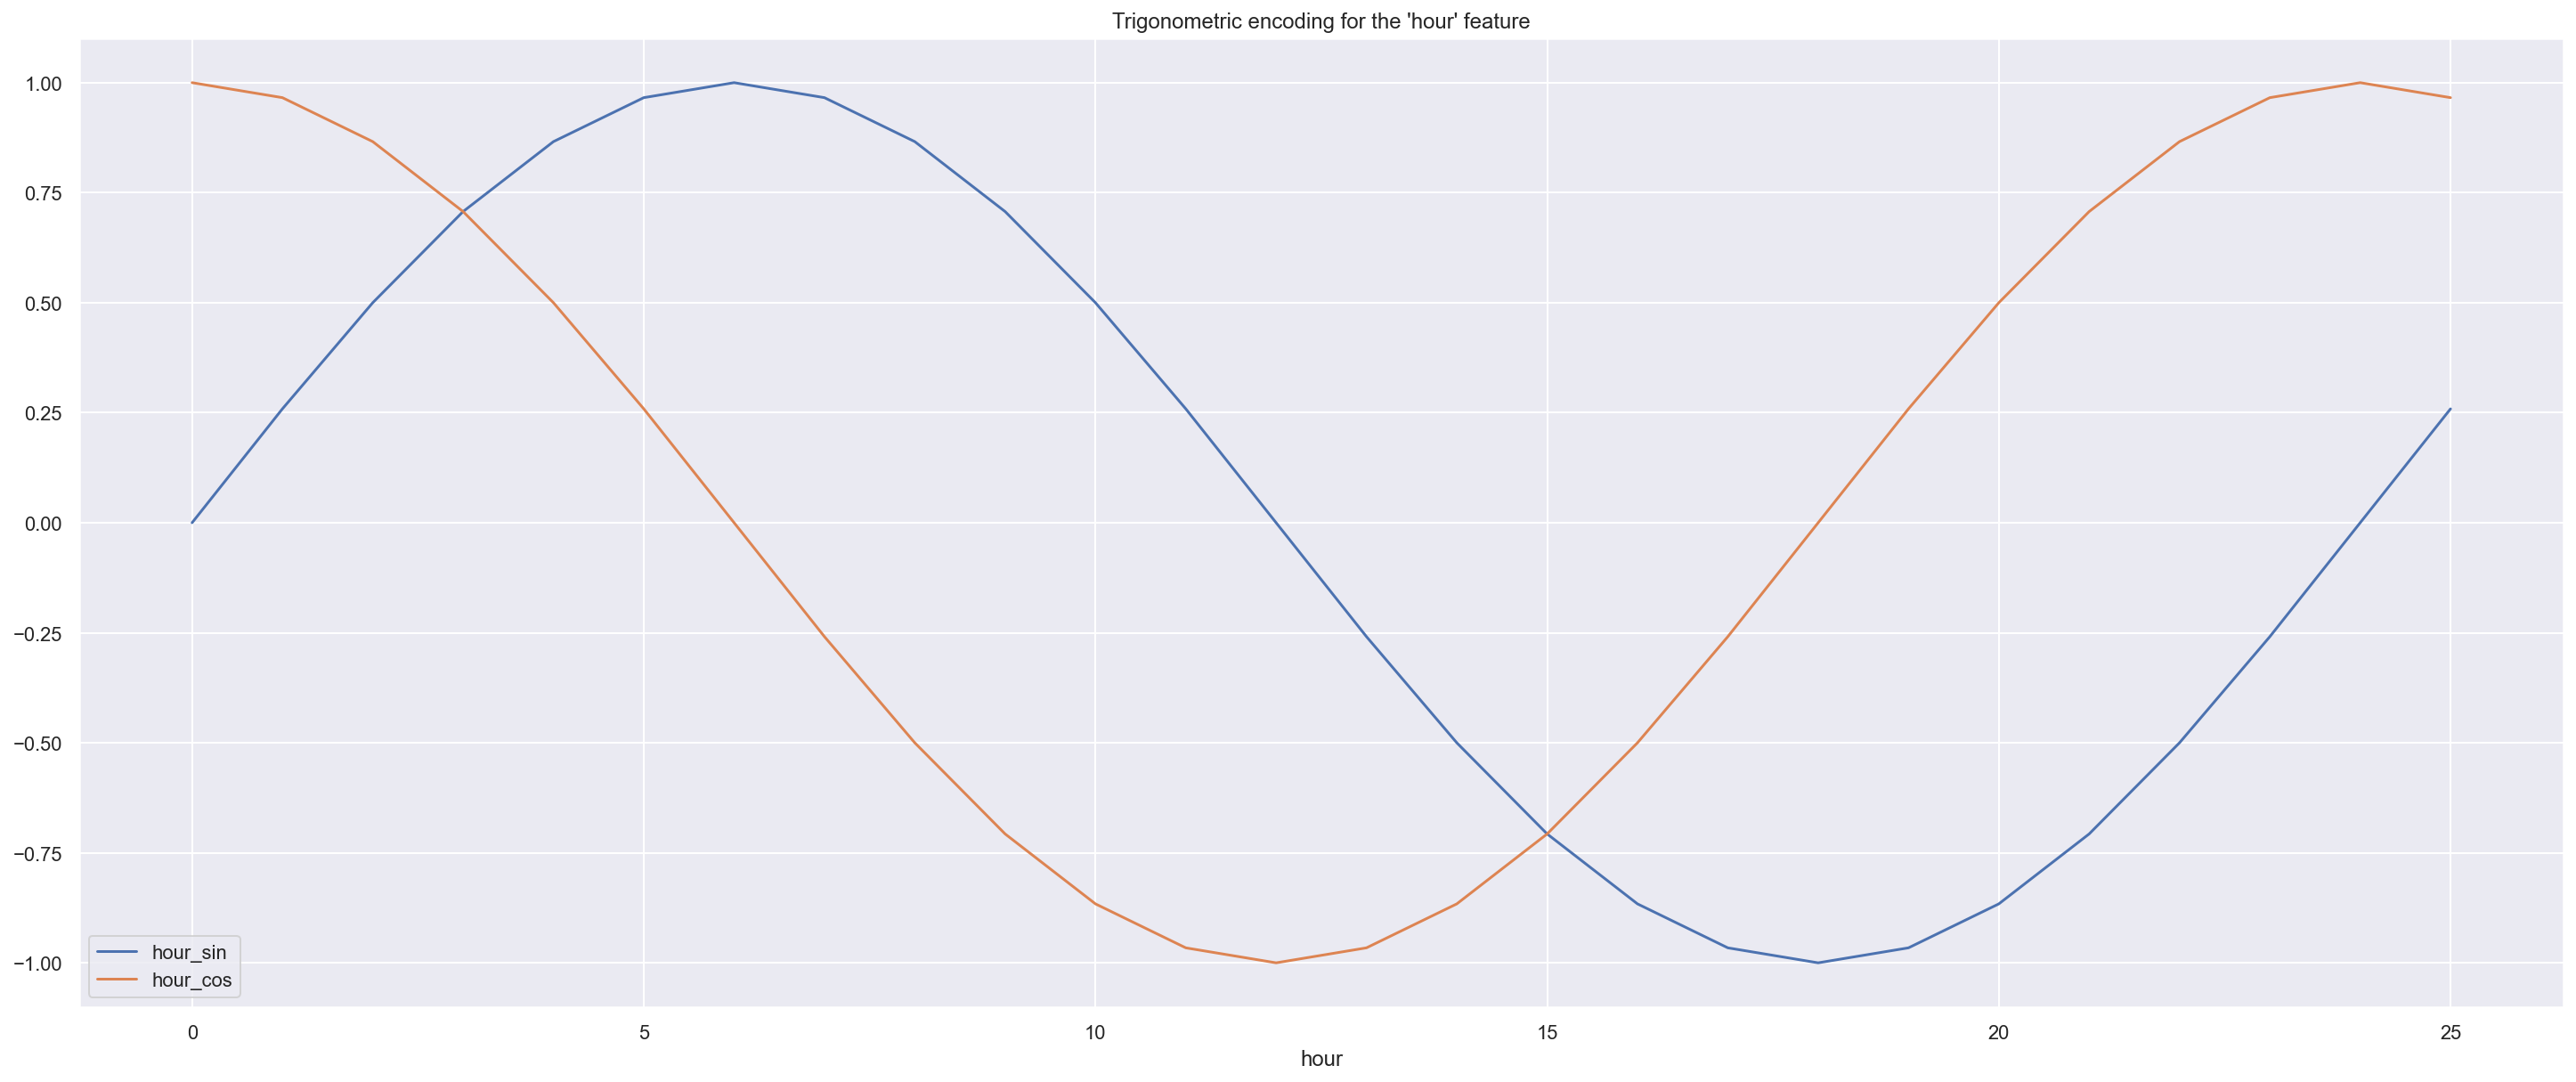

In [84]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["hour"],
)
hour_df["hour_sin"] = sin_transformer(period=24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(period=24).fit_transform(hour_df)["hour"]
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

To better understand the transformation, let’s use a 2D scatter plot with the hours encoded as colors to better see how this representation maps the 24 hours of the day to a 2D space, akin to some sort of a $24$ hour version of an analog clock. Note that the “$25^\mathrm{th}$” hour is mapped back to the 1st hour because of the periodic nature of the sine/cosine representation.

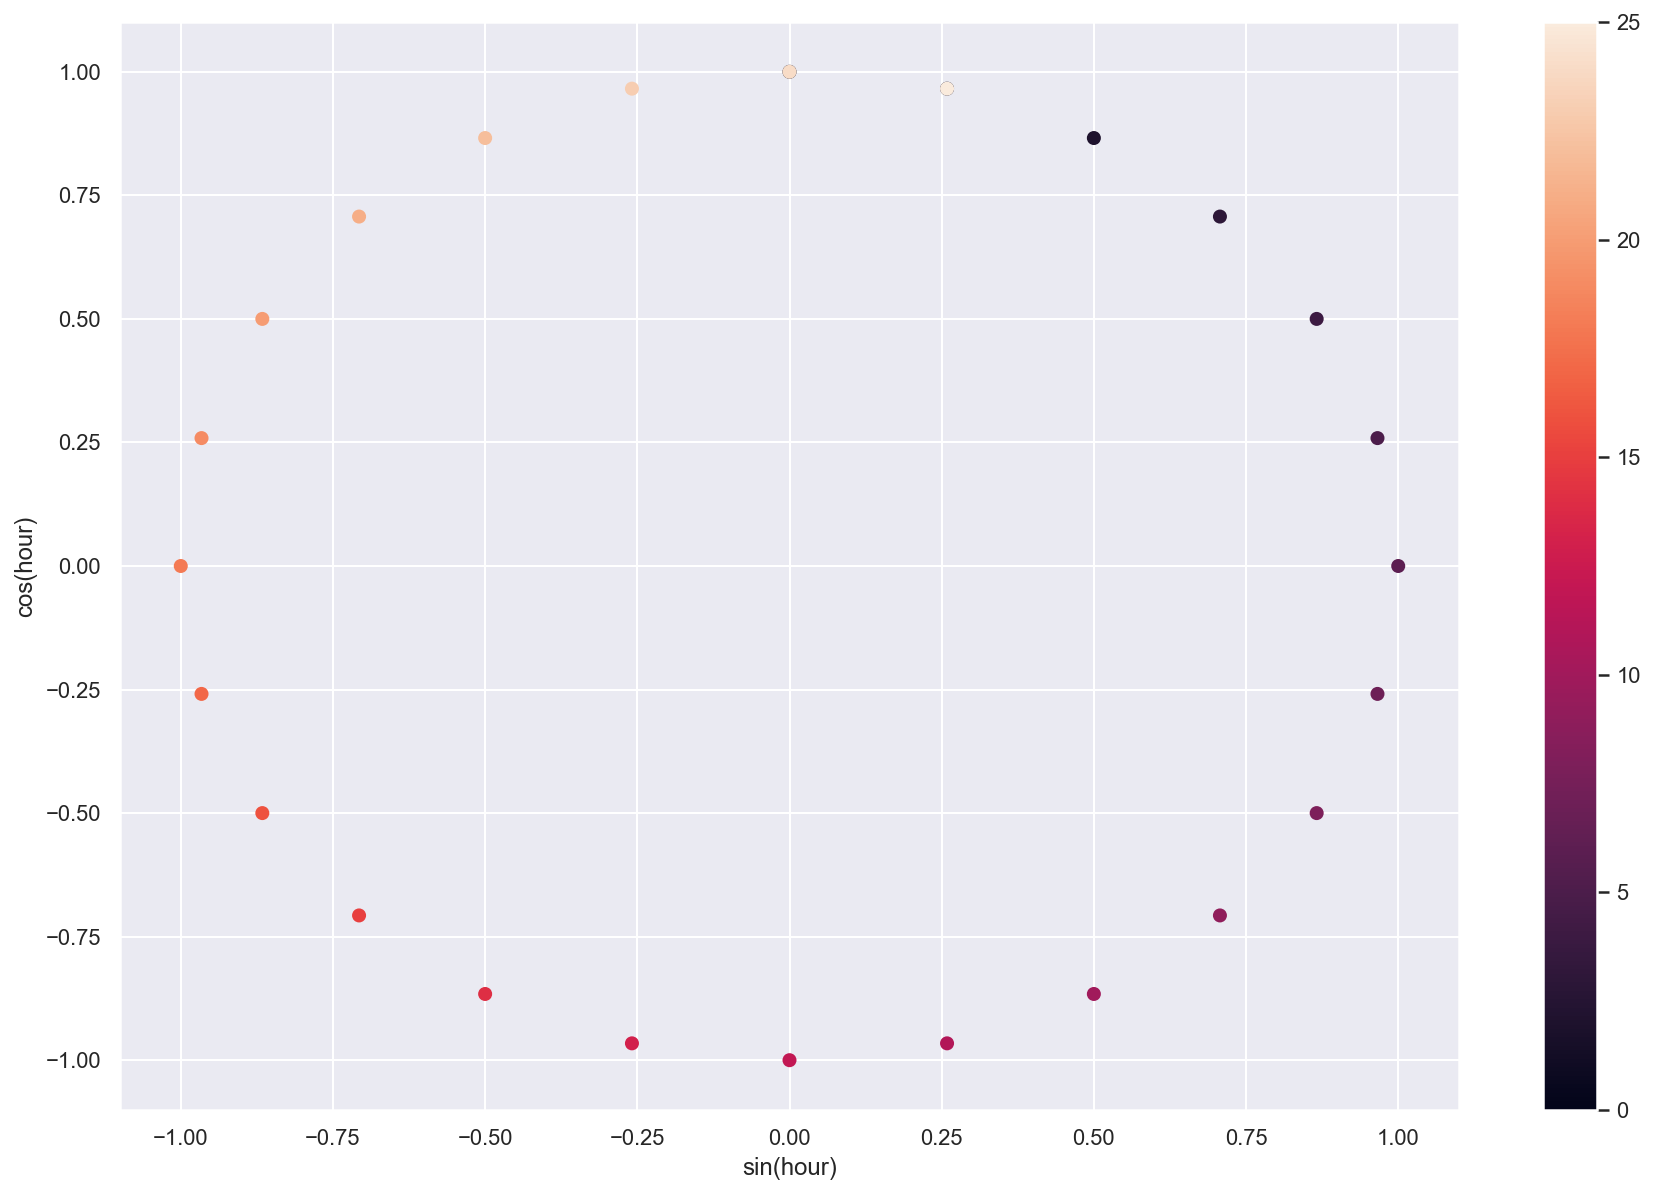

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

We can now build a feature extraction pipeline using this strategy.

In [51]:
# Period encoding pipeline

cyclic_encoding_transformer = ColumnTransformer(
    transformers=[
        ("ord_seas_year_month_hr", IdentityTransformer(), [0, 1]),
        ("month_sin", sin_transformer(12), [2]),
        ("month_cos", cos_transformer(12), [2]),
        ("hour_sin", sin_transformer(24), [3]),
        ("hour_cos", cos_transformer(24), [3]),
        ("do_nothing", IdentityTransformer(), [4]),
        ("weekday_sin", sin_transformer(7), [5]),
        ("weekday_cos", cos_transformer(7), [5]),
        ("do_nothing_again", IdentityTransformer(), [6, 7]),
        ("rescale", MinMaxScaler(), [8, 9, 10, 11]),
        # ("lag_cnt", lag_tranformer, [14]),
    ])

preprocessing_composed = Pipeline(steps=[
                                    ("resample", resample_transformer), # This drops some columns
                                    ("impute", knn_imputer),
                                    ("scale_and_encode", cyclic_encoding_transformer),
                                   # ("drop_lags", remove_lag_nan_tranformer),
])


cyclic_cossin_linear_pipeline = Pipeline(steps=[("preprocessing_encoding", preprocessing_composed),
                                                ("model", RidgeCV(alphas=alphas))
                                                ])

cyclic_cossin_linear_pipeline.fit(train_df, train_y)

cyclic_score = calculate_score(model=cyclic_cossin_linear_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
cyclic_score_r2 = calculate_score(model=cyclic_cossin_linear_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
cyclic_score_mape = calculate_score(model=cyclic_cossin_linear_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
cyclic_score_mse = calculate_score(model=cyclic_cossin_linear_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -122.16413241234288
            - neg_mean_absolute_error_standard_dev: 31.062497174051657
Results: 
            - r2: 0.27009945745535985
            - r2_standard_dev: 0.05031348728868188
Results: 
            - neg_mean_absolute_percentage_error: -3.861481029550494
            - neg_mean_absolute_percentage_error_standard_dev: 0.7638020416364334
Results: 
            - neg_mean_squared_error: -26146.093885454262
            - neg_mean_squared_error_standard_dev: 10965.71773881674


In [52]:
cyclic_predictions = cyclic_cossin_linear_pipeline.predict(test_X)

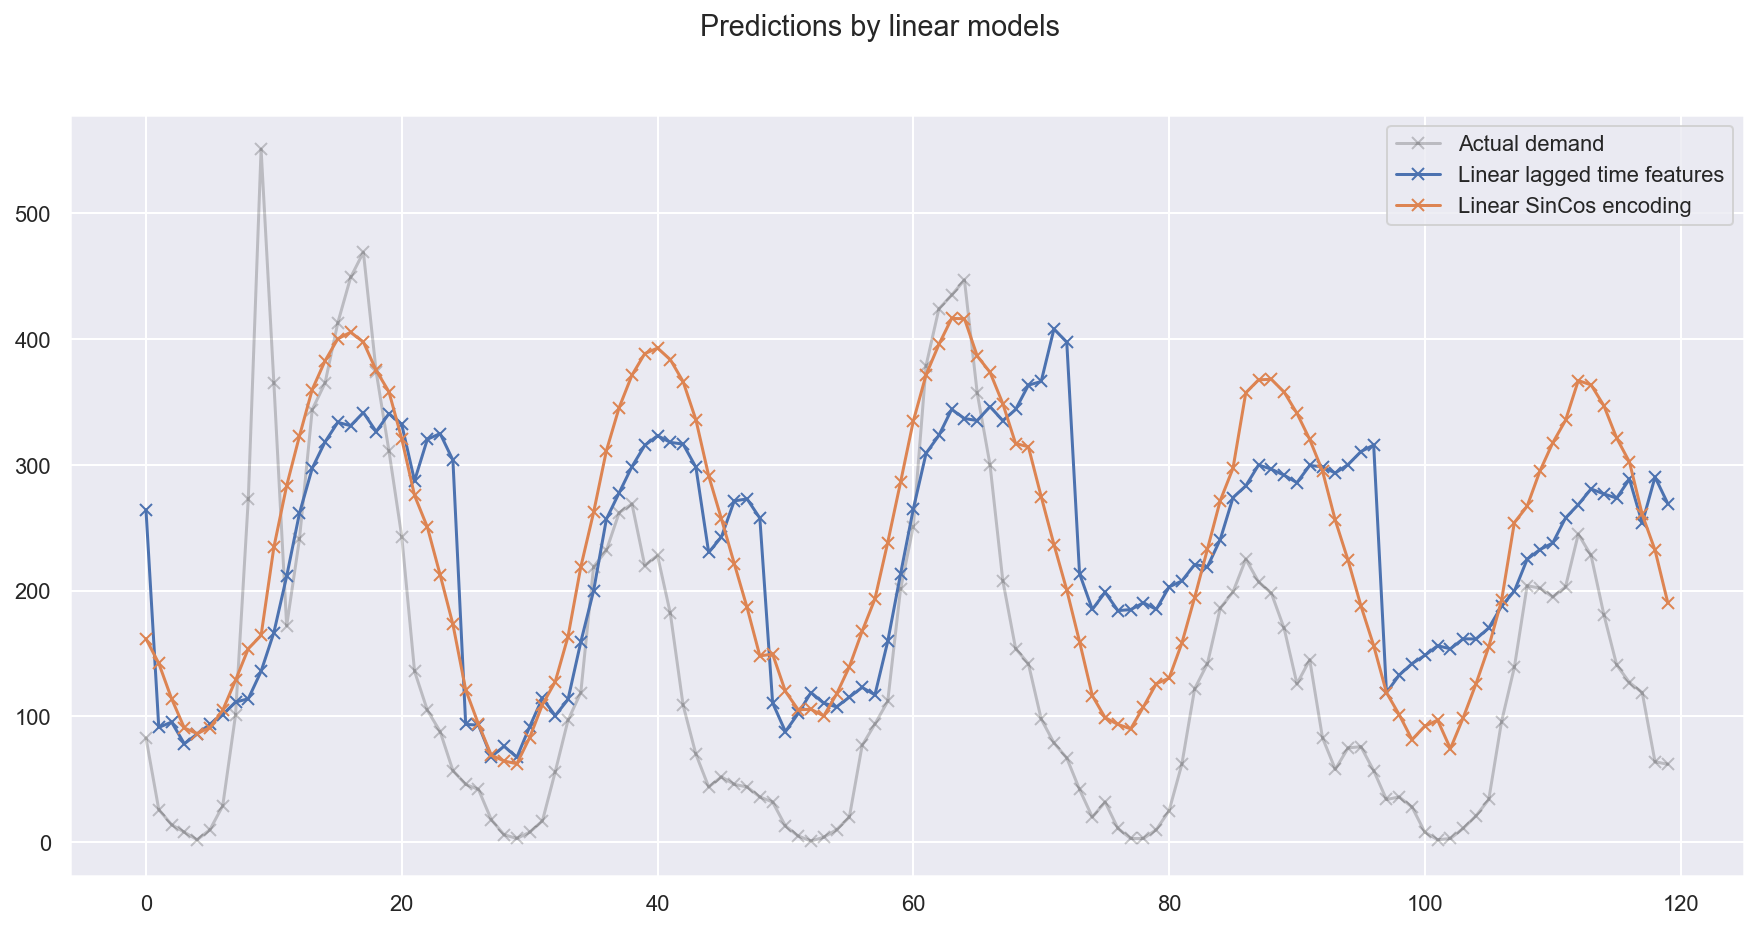

In [53]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by linear models")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    base_linear_predictions[last_hours],
    "x-",
    label="Linear lagged time features",
)
ax.plot(
    cyclic_predictions[last_hours],
    "x-",
    label="Linear SinCos encoding",
)
_ = ax.legend()

### Interactions between features

Linear models do not automatically capture interaction effects between input features. 
It does not help that some features are marginally non-linear as is the case with features constructed by OneHot encoding.

However, it is possible to use the `PolynomialFeatures` class on encoded hours to model the “workingday”/”hours” interaction explicitly without introducing too many new variables.

In [54]:
hour_workday_interaction = Pipeline(steps=[("interactions",
    ColumnTransformer(
        [
            ("cyclic_hour", sin_transformer(12), [3]),
            ("workingday", IdentityTransformer(), [6]),
        ]
    )),
    ("polinomial_feat", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))],
)

interaction_composed = Pipeline(steps=[
                                ("resample", resample_transformer), # This drops some columns
                                ("impute", knn_imputer),
                                ("interactions", hour_workday_interaction)])

cyclic_cossin_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", preprocessing_composed),
            ("interactions", interaction_composed),
        ], 
        transformer_weights={"marginal": 0.1, "interactions":0.9},
    ),
    RidgeCV(alphas=alphas),
)

In [55]:
cyclic_cossin_interactions_pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('marginal',
                                                 Pipeline(steps=[('resample',
                                                                  FunctionTransformer(func=<function resample_array at 0x292f32160>)),
                                                                 ('impute',
                                                                  KNNImputer(n_neighbors=2)),
                                                                 ('scale_and_encode',
                                                                  ColumnTransformer(transformers=[('ord_seas_year_month_hr',
                                                                                                   IdentityTransformer(),
                                                                                                   [0,
                                                                                                    1]),
                                                                                                  ('month_sin',
                                                                                                   FunctionTransformer(func=...
                                                   'marginal': 0.1})),
                ('ridgecv',
                 RidgeCV(alphas=array([1.25892541e+00, 2.01958975e+00, 3.23986054e+00, 5.19743987e+00,
       8.33782223e+00, 1.33756775e+01, 2.14574914e+01, 3.44224760e+01,
       5.52211267e+01, 8.85866790e+01, 1.42112271e+02, 2.27978944e+02,
       3.65727734e+02, 5.86706707e+02, 9.41204967e+02, 1.50989716e+03,
       2.42220294e+03, 3.88573952e+03, 6.23357002e+03, 1.00000000e+04])))])

Hence, let's calculate the score of this model.

In [56]:
cyclic_cossin_interactions_pipeline.fit(train_df, train_y)

cyclic_inter_score = calculate_score(model=cyclic_cossin_interactions_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
cyclic_inter_score_r2 = calculate_score(model=cyclic_cossin_interactions_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
cyclic_inter_score_mape = calculate_score(model=cyclic_cossin_interactions_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
cyclic_inter_score_mse = calculate_score(model=cyclic_cossin_interactions_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -122.16413241234288
            - neg_mean_absolute_error_standard_dev: 31.062497174051657
Results: 
            - r2: 0.27009945745535985
            - r2_standard_dev: 0.05031348728868188
Results: 
            - neg_mean_absolute_percentage_error: -3.861481029550494
            - neg_mean_absolute_percentage_error_standard_dev: 0.7638020416364334
Results: 
            - neg_mean_squared_error: -26146.093885454262
            - neg_mean_squared_error_standard_dev: 10965.71773881674


In [57]:
interaction_predictions = cyclic_cossin_interactions_pipeline.predict(test_X)

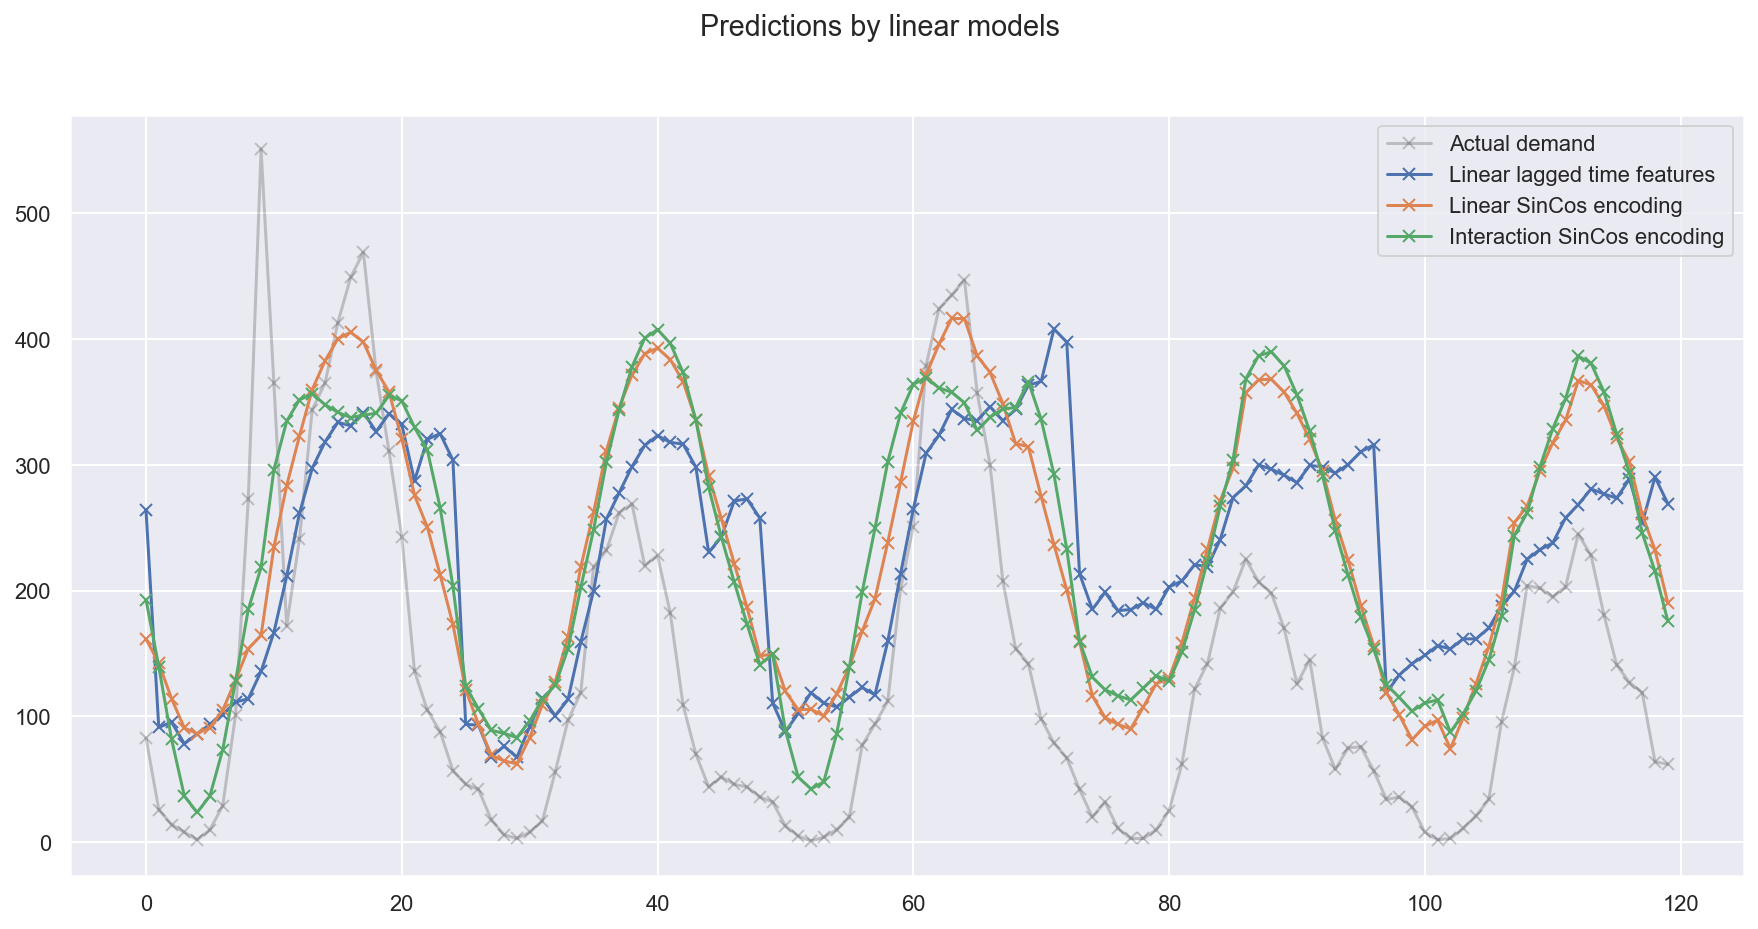

In [58]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by linear models")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    base_linear_predictions[last_hours],
    "x-",
    label="Linear lagged time features",
)
ax.plot(
    cyclic_predictions[last_hours],
    "x-",
    label="Linear SinCos encoding",
)
ax.plot(
    interaction_predictions[last_hours],
    "x-",
    label="Interaction SinCos encoding",
)
_ = ax.legend()

### Non-linear models

Now let's create something more complex: non linear models. 

The main idea is to find a couple of good models and then create an ensemble model out of them.

#### Random Forest

Let's start by a random forest regression model.

The good news is that all the work we have already done for the linear regression models is not useless.
We just need to slightly modify the pipelines above to include the XGBoost regression model.

In [59]:
# Random Forest pipeline
## Execution time: ~5 minutes

cyclic_encoding_transformer = ColumnTransformer(
    transformers=[
        ("ord_seas_year_month_hr", IdentityTransformer(), [0, 1]),
        ("month_sin", sin_transformer(12), [2]),
        ("month_cos", cos_transformer(12), [2]),
        ("hour_sin", sin_transformer(24), [3]),
        ("hour_cos", cos_transformer(24), [3]),
        ("do_nothing", IdentityTransformer(), [4]),
        ("weekday_sin", sin_transformer(7), [5]),
        ("weekday_cos", cos_transformer(7), [5]),
        ("do_nothing_again", IdentityTransformer(), [6, 7]),
        ("rescale", MinMaxScaler(), [8, 9, 10, 11]),
        # ("lag_cnt", lag_tranformer, [14]),
    ])

preprocessing_composed = Pipeline(steps=[
                                    ("resample", resample_transformer), # This drops some columns
                                    ("impute", knn_imputer),
                                    ("scale_and_encode", cyclic_encoding_transformer),
                                   # ("drop_lags", remove_lag_nan_tranformer),
])

rf_hyperparams = {
    "n_estimators":1000, 
    "criterion": "squared_error",
    "max_depth": 7,
    "min_samples_split": 3,
    "min_samples_leaf": 2,
    "max_samples": 0.7,
    "random_state": 42}

rf_pipeline = Pipeline(steps=[("preprocessing_encoding", preprocessing_composed),
                                                ("model", RandomForestRegressor(**rf_hyperparams))
                                                ])

rf_pipeline.fit(train_df, train_y)

rf_score = calculate_score(model=rf_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
rf_score_r2 = calculate_score(model=rf_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
rf_score_mape = calculate_score(model=rf_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
rf_score_mse = calculate_score(model=rf_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -66.53910627770833
            - neg_mean_absolute_error_standard_dev: 12.958789321643323
Results: 
            - r2: 0.6633492496397201
            - r2_standard_dev: 0.14535818485405647
Results: 
            - neg_mean_absolute_percentage_error: -0.4528980331284408
            - neg_mean_absolute_percentage_error_standard_dev: 0.186522445242165
Results: 
            - neg_mean_squared_error: -10830.739839721982
            - neg_mean_squared_error_standard_dev: 4159.051756110206


In [62]:
rf_predictions = rf_pipeline.predict(test_X)

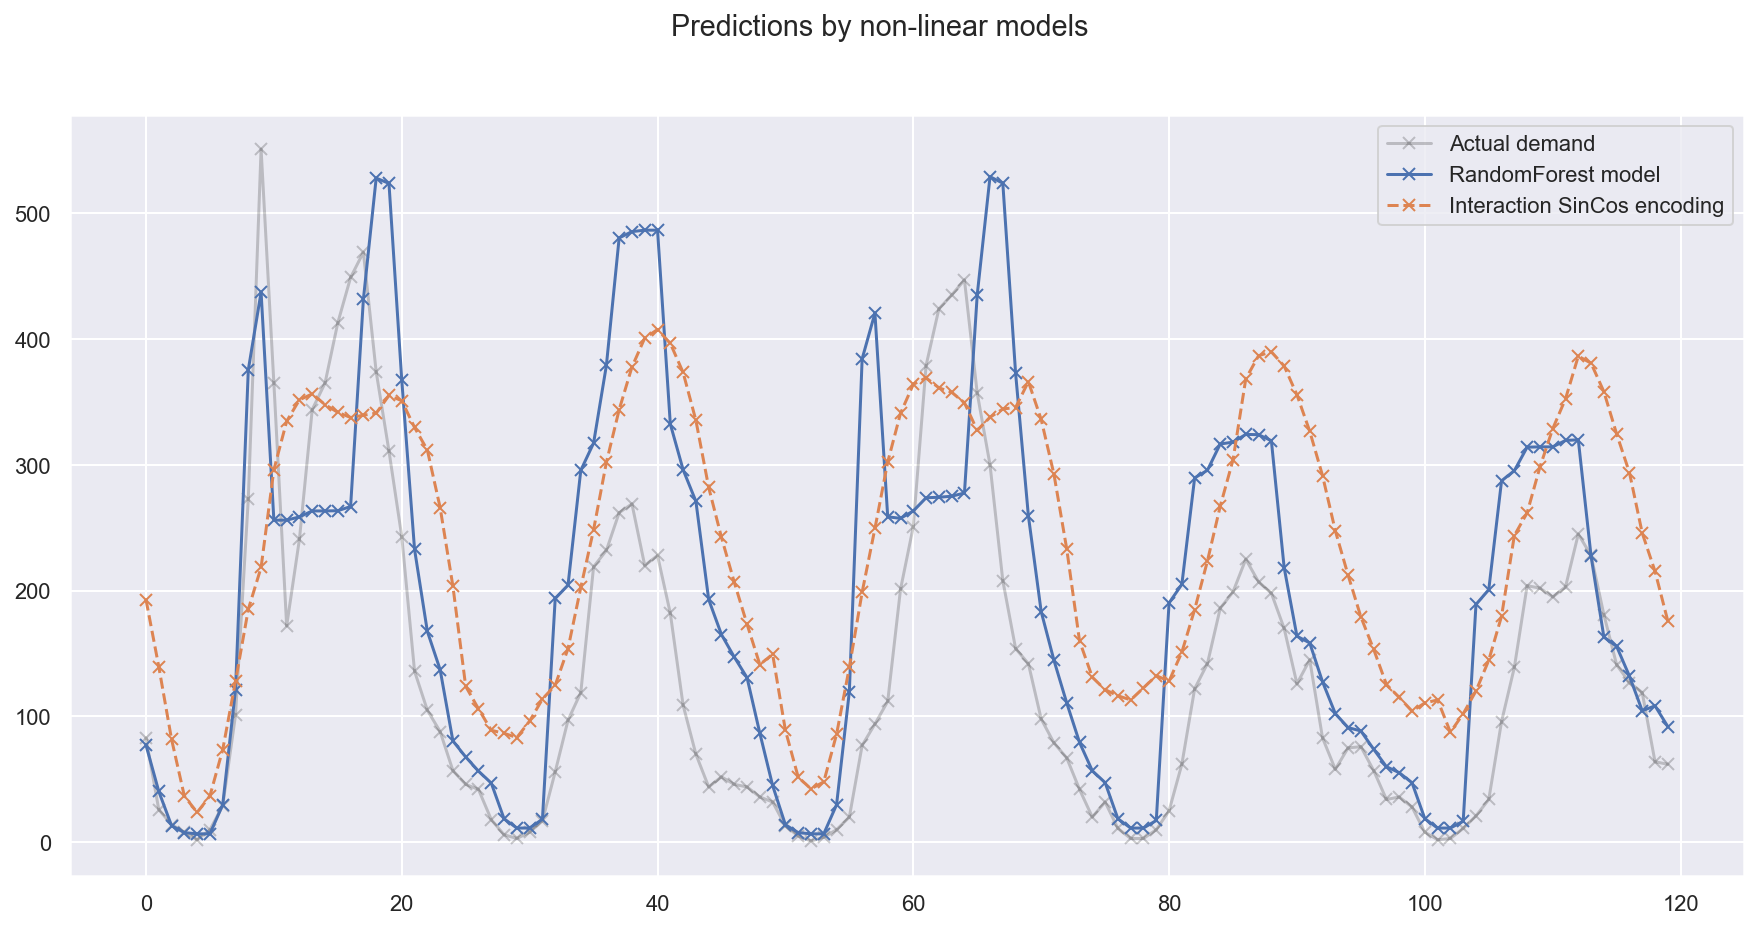

In [61]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by non-linear models")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    rf_predictions[last_hours],
    "x-",
    label="RandomForest model",
)
ax.plot(
    interaction_predictions[last_hours],
    "x--",
    label="Interaction SinCos encoding",
)
_ = ax.legend()

Quite better than linear models, but we can go on. 

The attentive reader might have noticed that we never used lagged features until now.
This is what we want to do now to further improve the performance of the model.


In [63]:
# Random Forest pipeline with lag_cnt
## Execution time: ~5 minutes

lags = 24

cyclic_encoding_lag_transformer = ColumnTransformer(
    transformers=[
        ("ord_seas_year_month_hr", IdentityTransformer(), [0, 1]),
        ("month_sin", sin_transformer(12), [2]),
        ("month_cos", cos_transformer(12), [2]),
        ("hour_sin", sin_transformer(24), [3]),
        ("hour_cos", cos_transformer(24), [3]),
        ("do_nothing", IdentityTransformer(), [4]),
        ("weekday_sin", sin_transformer(7), [5]),
        ("weekday_cos", cos_transformer(7), [5]),
        ("do_nothing_again", IdentityTransformer(), [6, 7]),
        ("rescale", MinMaxScaler(), [8, 9, 10, 11]),
        ("lag_cnt", lag_tranformer, [14]),
    ])

preprocessing_lag_composed = Pipeline(steps=[
                                    ("resample", resample_transformer), # This drops some columns
                                    ("impute", knn_imputer),
                                    ("scale_and_encode", cyclic_encoding_lag_transformer),
                                    ("drop_lags", remove_lag_nan_tranformer),
])

rf_hyperparams = {
    "n_estimators":1000, 
    "criterion": "squared_error",
    "max_depth": 7,
    "min_samples_split": 3,
    "min_samples_leaf": 2,
    "max_samples": 0.7,
    "random_state": 42}

rf_lag_pipeline = Pipeline(steps=[("preprocessing_encoding", preprocessing_lag_composed),
                                                ("model", RandomForestRegressor(**rf_hyperparams))
                                                ])

rf_lag_pipeline.fit(train_df, train_y[lags:])

rf_lag_score = calculate_score(model=rf_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
rf_lag_score_r2 = calculate_score(model=rf_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
rf_lag_score_mape = calculate_score(model=rf_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
rf_lag_score_mse = calculate_score(model=rf_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -66.53910627770833
            - neg_mean_absolute_error_standard_dev: 12.958789321643323
Results: 
            - r2: 0.6633492496397201
            - r2_standard_dev: 0.14535818485405647
Results: 
            - neg_mean_absolute_percentage_error: -0.4528980331284408
            - neg_mean_absolute_percentage_error_standard_dev: 0.186522445242165
Results: 
            - neg_mean_squared_error: -10830.739839721982
            - neg_mean_squared_error_standard_dev: 4159.051756110206


In [64]:
rf_lag_predictions = rf_lag_pipeline.predict(test_X)

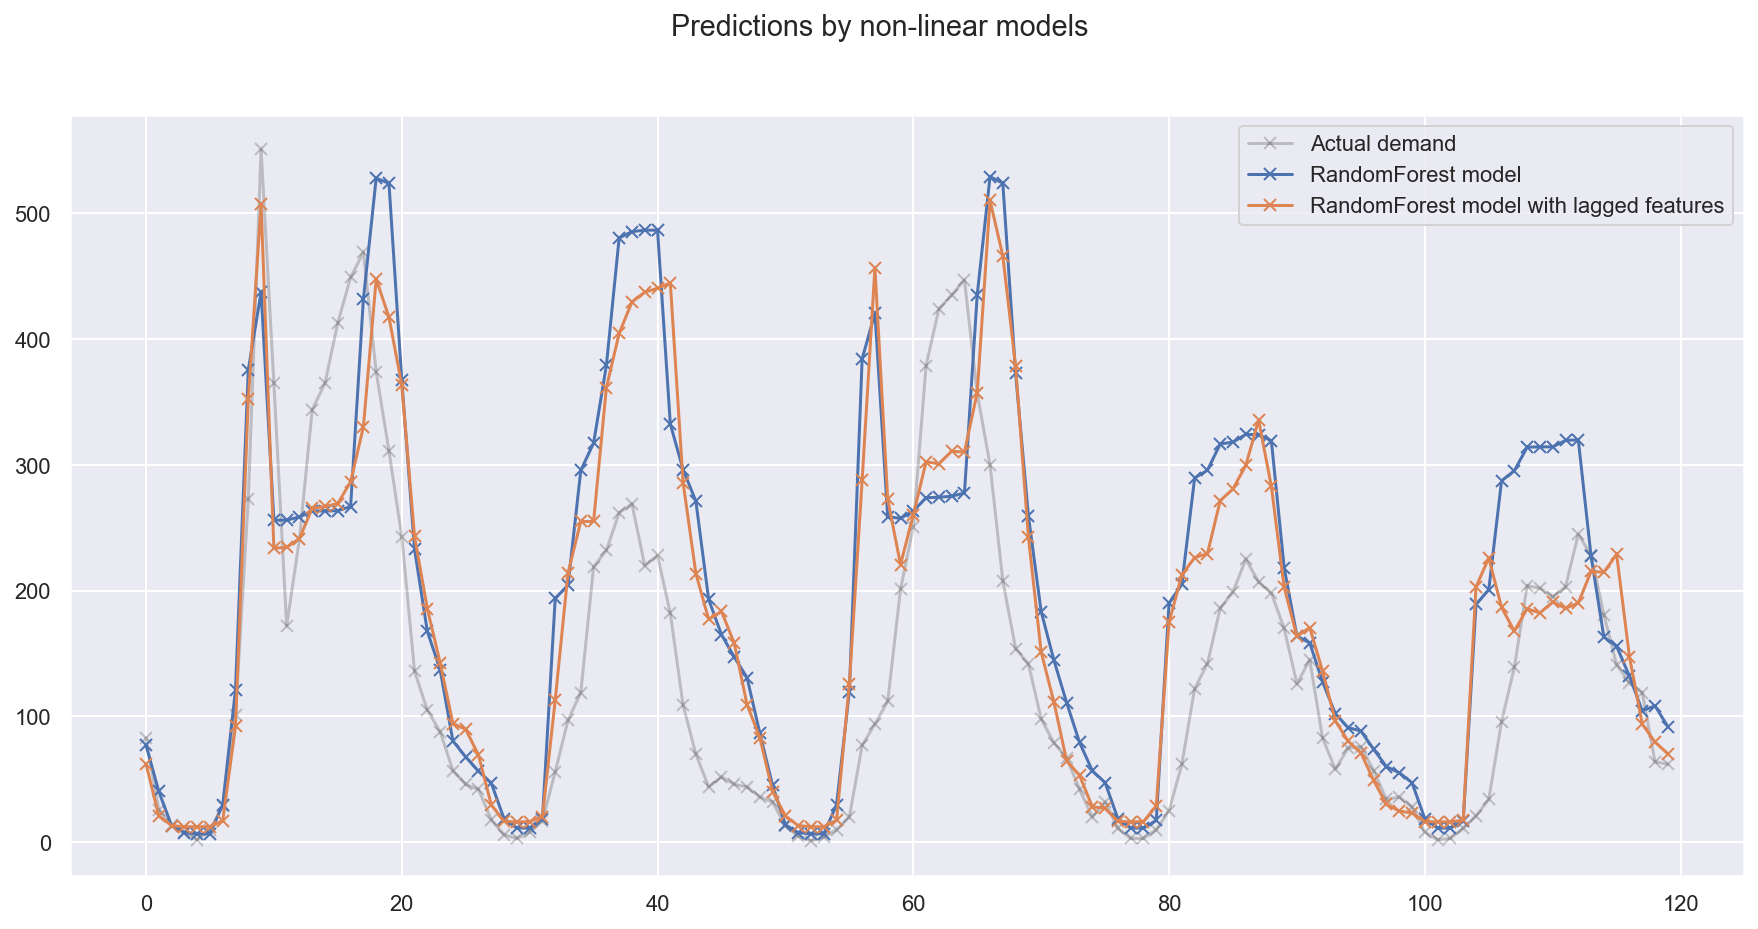

In [65]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by non-linear models")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    rf_predictions[last_hours],
    "x-",
    label="RandomForest model",
)
ax.plot(
    rf_lag_predictions[last_hours],
    "x-",
    label="RandomForest model with lagged features",
)
_ = ax.legend()

#### XGBoost

Finally, we conclude by the XGBoost regression model.

In [67]:
# XGBoost pipeline
## Execution time: ~8 minutes

cyclic_encoding_transformer = ColumnTransformer(
    transformers=[
        ("ord_seas_year_month_hr", IdentityTransformer(), [0, 1]),
        ("month_sin", sin_transformer(12), [2]),
        ("month_cos", cos_transformer(12), [2]),
        ("hour_sin", sin_transformer(24), [3]),
        ("hour_cos", cos_transformer(24), [3]),
        ("do_nothing", IdentityTransformer(), [4]),
        ("weekday_sin", sin_transformer(7), [5]),
        ("weekday_cos", cos_transformer(7), [5]),
        ("do_nothing_again", IdentityTransformer(), [6, 7]),
        ("rescale", MinMaxScaler(), [8, 9, 10, 11]),
        # ("lag_cnt", lag_tranformer, [14]),
    ])

preprocessing_composed = Pipeline(steps=[
                                    ("resample", resample_transformer), # This drops some columns
                                    ("impute", knn_imputer),
                                    ("scale_and_encode", cyclic_encoding_transformer),
                                    # ("drop_lags", remove_lag_nan_tranformer),
])

xgb_hyperparams = {
    "n_estimators":1000, 
    "max_depth": 7,
    "eta": 0.1,
    "subsample": 0.7,
    "colsample_bytree": 0.9 }

xgb_pipeline = Pipeline(steps=[("preprocessing_encoding", preprocessing_composed),
                                                ("model", xgb.XGBRegressor(**xgb_hyperparams))
                                                ])

xgb_pipeline.fit(train_df, train_y)

xgb_score = calculate_score(model=xgb_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
xgb_score_r2 = calculate_score(model=xgb_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
xgb_score_mape = calculate_score(model=xgb_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
xgb_score_mse = calculate_score(model=xgb_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -46.43272194058628
            - neg_mean_absolute_error_standard_dev: 10.00245032688318
Results: 
            - r2: 0.8195333260849889
            - r2_standard_dev: 0.1580671745865106
Results: 
            - neg_mean_absolute_percentage_error: -0.5810537920375738
            - neg_mean_absolute_percentage_error_standard_dev: 0.1663482197654066
Results: 
            - neg_mean_squared_error: -4925.26839089047
            - neg_mean_squared_error_standard_dev: 1918.8019089374168


In [68]:
xgb_predictions = xgb_pipeline.predict(test_X)

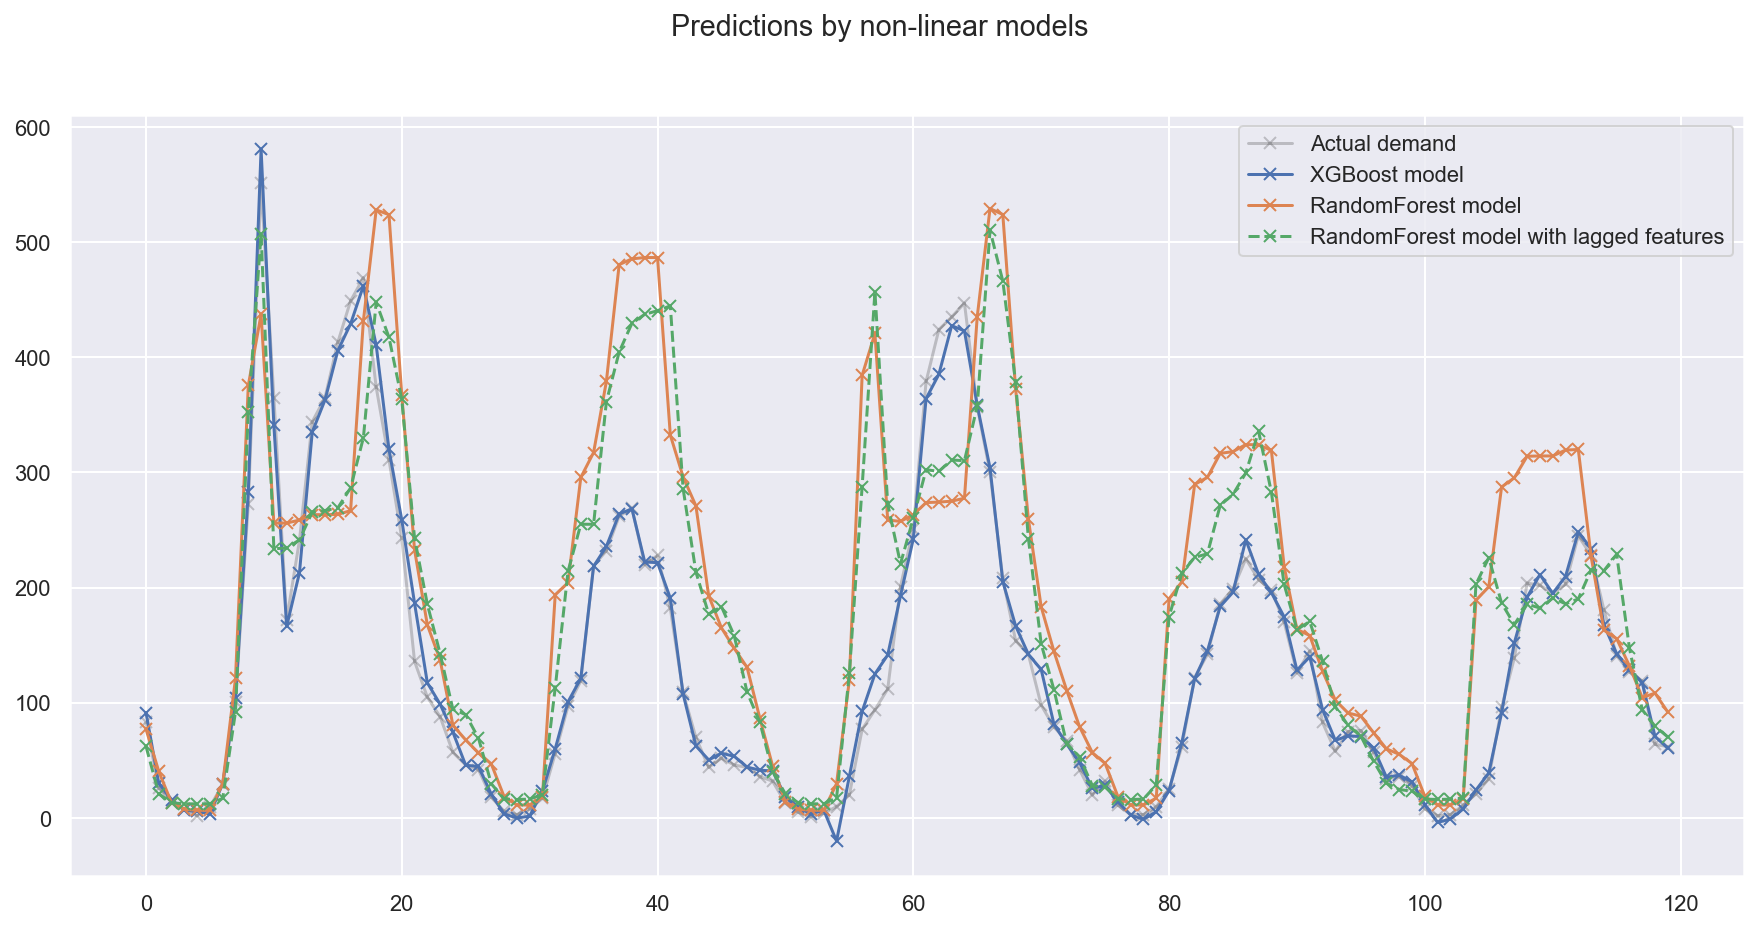

In [69]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by non-linear models")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    xgb_predictions[last_hours],
    "x-",
    label="XGBoost model",
)
ax.plot(
    rf_predictions[last_hours],
    "x-",
    label="RandomForest model",
)
ax.plot(
    rf_lag_predictions[last_hours],
    "x--",
    label="RandomForest model with lagged features",
)
_ = ax.legend()

Almost perfect! 
As before, let's insert the lagged features into the model to see if these increase model performances.


In [70]:
# XGBoost pipeline with lag_cnt
## Execution time: ~10 minutes

lags = 24
cyclic_encoding_lag_transformer = ColumnTransformer(
    transformers=[
        ("ord_seas_year_month_hr", IdentityTransformer(), [0, 1]),
        ("month_sin", sin_transformer(12), [2]),
        ("month_cos", cos_transformer(12), [2]),
        ("hour_sin", sin_transformer(24), [3]),
        ("hour_cos", cos_transformer(24), [3]),
        ("do_nothing", IdentityTransformer(), [4]),
        ("weekday_sin", sin_transformer(7), [5]),
        ("weekday_cos", cos_transformer(7), [5]),
        ("do_nothing_again", IdentityTransformer(), [6, 7]),
        ("rescale", MinMaxScaler(), [8, 9, 10, 11]),
        ("lag_cnt", lag_tranformer, [14]),
    ])

preprocessing_lag_composed = Pipeline(steps=[
                                    ("resample", resample_transformer), # This drops some columns
                                    ("impute", knn_imputer),
                                    ("scale_and_encode", cyclic_encoding_lag_transformer),
                                    ("drop_lags", remove_lag_nan_tranformer),
])

xgb_hyperparams = {
    "n_estimators":1000, 
    "max_depth": 7,
    "eta": 0.1,
    "subsample": 0.7,
    "colsample_bytree": 0.9 }

xgb_lag_pipeline = Pipeline(steps=[("preprocessing_encoding", preprocessing_lag_composed),
                                                ("model", xgb.XGBRegressor(**xgb_hyperparams))
                                                ])

xgb_lag_pipeline.fit(train_df, train_y[lags:])

xgb_lag_score = calculate_score(model=xgb_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
xgb_lag_score_r2 = calculate_score(model=xgb_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
xgb_lag_score_mape = calculate_score(model=xgb_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
xgb_lag_score_mse = calculate_score(model=xgb_lag_pipeline.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -46.43272194058628
            - neg_mean_absolute_error_standard_dev: 10.00245032688318
Results: 
            - r2: 0.8195333260849889
            - r2_standard_dev: 0.1580671745865106
Results: 
            - neg_mean_absolute_percentage_error: -0.5810537920375738
            - neg_mean_absolute_percentage_error_standard_dev: 0.1663482197654066
Results: 
            - neg_mean_squared_error: -4925.26839089047
            - neg_mean_squared_error_standard_dev: 1918.8019089374168


In [71]:
xgb_lag_predictions = xgb_lag_pipeline.predict(test_X)

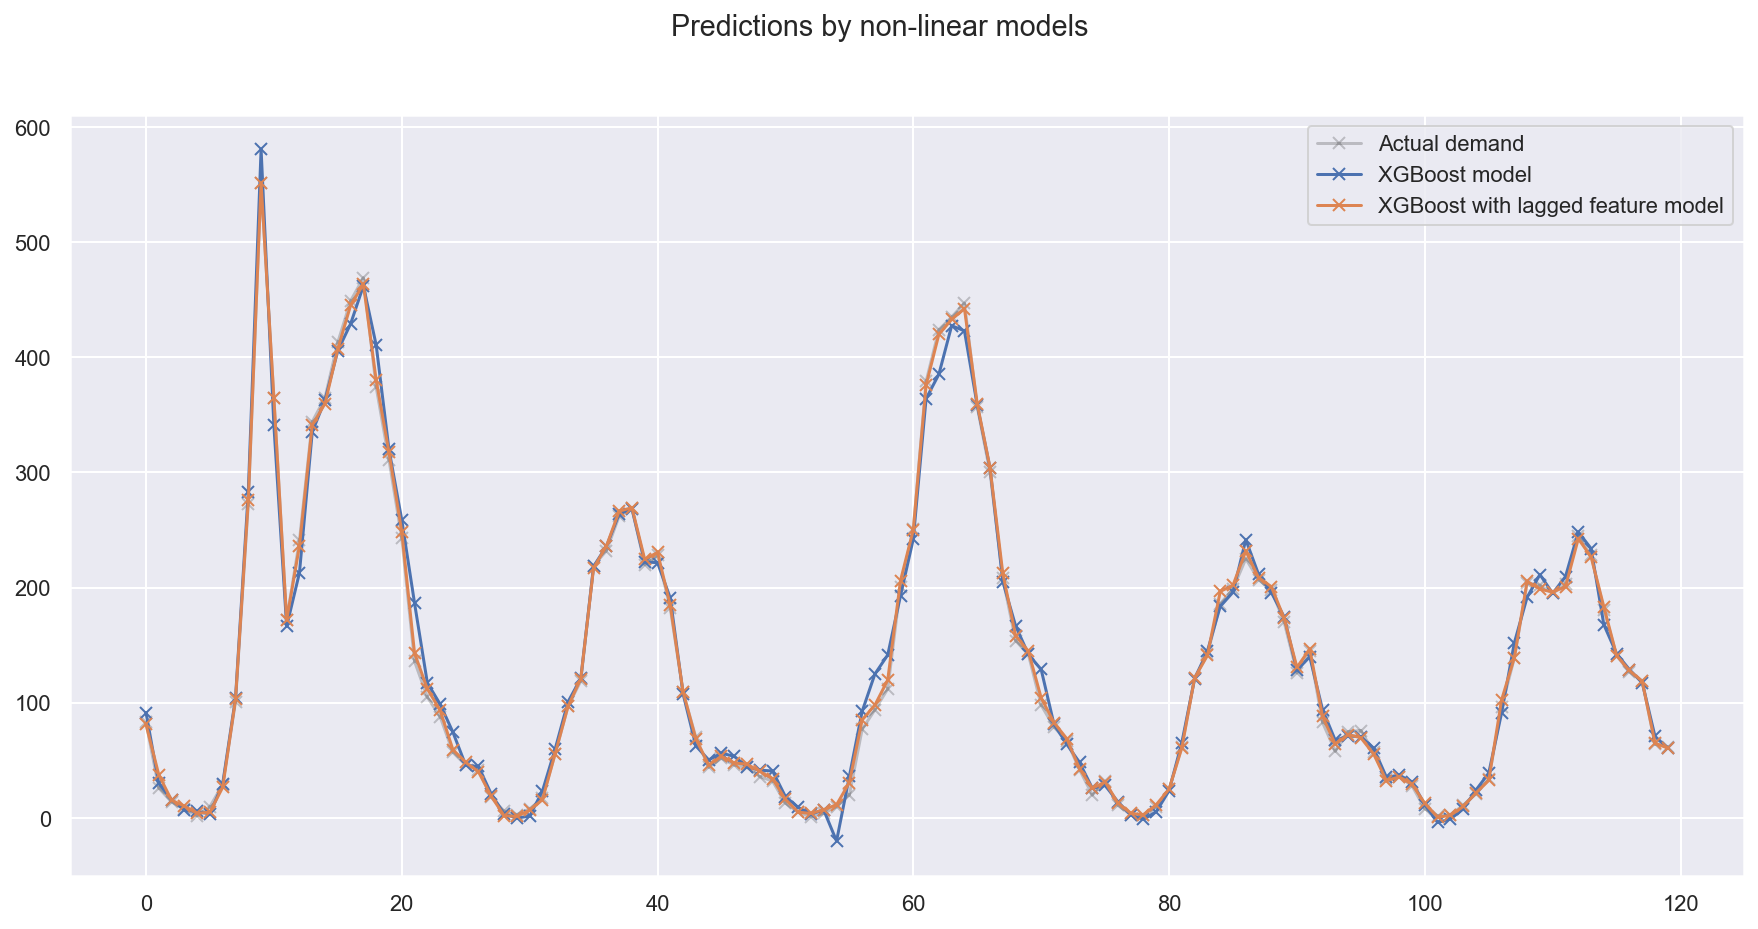

In [72]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by non-linear models")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    xgb_predictions[last_hours],
    "x-",
    label="XGBoost model",
)
ax.plot(
    xgb_lag_predictions[last_hours],
    "x-",
    label="XGBoost with lagged feature model",
)
_ = ax.legend()

Very close (also because the model was already quite good), however, we improved a little bit further.

We are now ready to the next step: hyperparameter tuning.

## HyperParameter tuning

Finally, we are get to the optimisation of the model. 
Our strategy is to perform hyperparameter tuning on the two best models and then create an ensemble model of the two.

Now, we need to choose the two best models above (they are unsurprisingly these are the RandomForest and the XGBOOST) to tune their hyperparameters.
We start by XGBoost, then we move forward to RandomForest.
The technique chose is RandomSearch for numerical and efficiency reasons.

### XGBoost RandomSearch

Here we proceed with RandomSearch to explore the XGBoost hyperparameter space.

A nice guide a courious reader might find useful is [here](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook).

In [73]:
# Hyperparameter space grid

hparam_grid = {
    "booster": ["gbtree", "gblinear"],
    "max_depth": [5, 7, 9, 11],
    "learning_rate": [0.2, 0.1, 0.05],
    "eta": [0.1, 0.5, 0.75],
    "reg_lambda": [0, 3],
    "colsample_bytree": [0.5, 0.7, 0.8],
}

In [74]:
## CAREFUL: This might take a while.

# Init Model
xgb_model = xgb.XGBRegressor()

# Init Cross-validation split
tscv = TimeSeriesSplit(n_splits=7, max_train_size=120)

# Init Random Search
rnd_cv_xgb = RandomizedSearchCV(xgb_model, hparam_grid, n_jobs=-1, cv=tscv, scoring="neg_mean_absolute_percentage_error")

# Fit
X_train_pr = xgb_pipeline.named_steps["preprocessing_encoding"].fit_transform(train_df)
_ = rnd_cv_xgb.fit(X_train_pr, train_y)

joblib.dump(rnd_cv_xgb, "models/xgb_rnd_cv.joblib")

[16:58:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytree", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.

[16:58:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytree", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



[16:58:53] WARNING: /Users/runner/work/xgboost/xgboost/python-pa

['models/xgb_rnd_cv.joblib']

### Random Forest optimisation

To conclude this section, we need to perform random search of optimal hyperparameters also on the Random Forest model.

As above, we proceed with the random search algorithm.

In [75]:
# Hyperparameter space grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None) # to see whether the unlimited trees are better.

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

hparam_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
} 

In [76]:
## CAREFUL: This might take a while.

# Init Model
rf_model = RandomForestRegressor()

# Init Cross-validation split
tscv = TimeSeriesSplit(n_splits=7, max_train_size=120)

# Init Random Search
rnd_cv_rf = RandomizedSearchCV(rf_model, hparam_grid, n_jobs=-1, cv=tscv, scoring="neg_mean_absolute_percentage_error")

# Fit
X_train_pr = rf_pipeline.named_steps["preprocessing_encoding"].fit_transform(train_df)
_ = rnd_cv_rf.fit(X_train_pr, train_y)

joblib.dump(rnd_cv_rf, "models/rf_rnd_cv.joblib")

['models/rf_rnd_cv.joblib']

## Ensemble the models

We are at the end of this long process. 
What is left is simply put together the results of the two optimised models we found.

The ensemble procedure we are going to put in place makes use of the [`VotingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) object.

Let's have a look at the code.

In [78]:
# Final Model construction

# Load Random Forest
rf_cv = joblib.load("models/rf_rnd_cv.joblib")
final_rf = rf_cv.best_estimator_

# Load XGBoost
xgb_cv = joblib.load("models/xgb_rnd_cv.joblib")
final_xgb = xgb_cv.best_estimator_

# Voting Regressor Model
final_model = VotingRegressor(estimators=[("randomForest",final_rf), ("XGBoost",final_xgb)])

final_pipe = Pipeline(steps=[
    ("preprocessing", preprocessing_composed),
    ("model", final_model)                            
])

final_pipe.fit(train_df, train_y)

final_score = calculate_score(model=final_pipe.steps[-1][1], X_train=train_X, y_train=train_y, n_splits = 10)
final_score_r2 = calculate_score(model=final_pipe.steps[-1][1], X_train=train_X, y_train=train_y, scoring="r2", n_splits = 10)
final_score_mape = calculate_score(model=final_pipe.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_absolute_percentage_error", n_splits = 10)
final_score_mse = calculate_score(model=final_pipe.steps[-1][1], X_train=train_X, y_train=train_y, scoring="neg_mean_squared_error", n_splits = 10)

Results: 
            - neg_mean_absolute_error: -49.87943384631668
            - neg_mean_absolute_error_standard_dev: 9.636376082947427
Results: 
            - r2: 0.7855605770470682
            - r2_standard_dev: 0.14609490474537198
Results: 
            - neg_mean_absolute_percentage_error: -0.4974106433843929
            - neg_mean_absolute_percentage_error_standard_dev: 0.14784392448789457
Results: 
            - neg_mean_squared_error: -6177.377431986892
            - neg_mean_squared_error_standard_dev: 2178.1293766762706


In [79]:
final_predictions = final_pipe.predict(test_X)

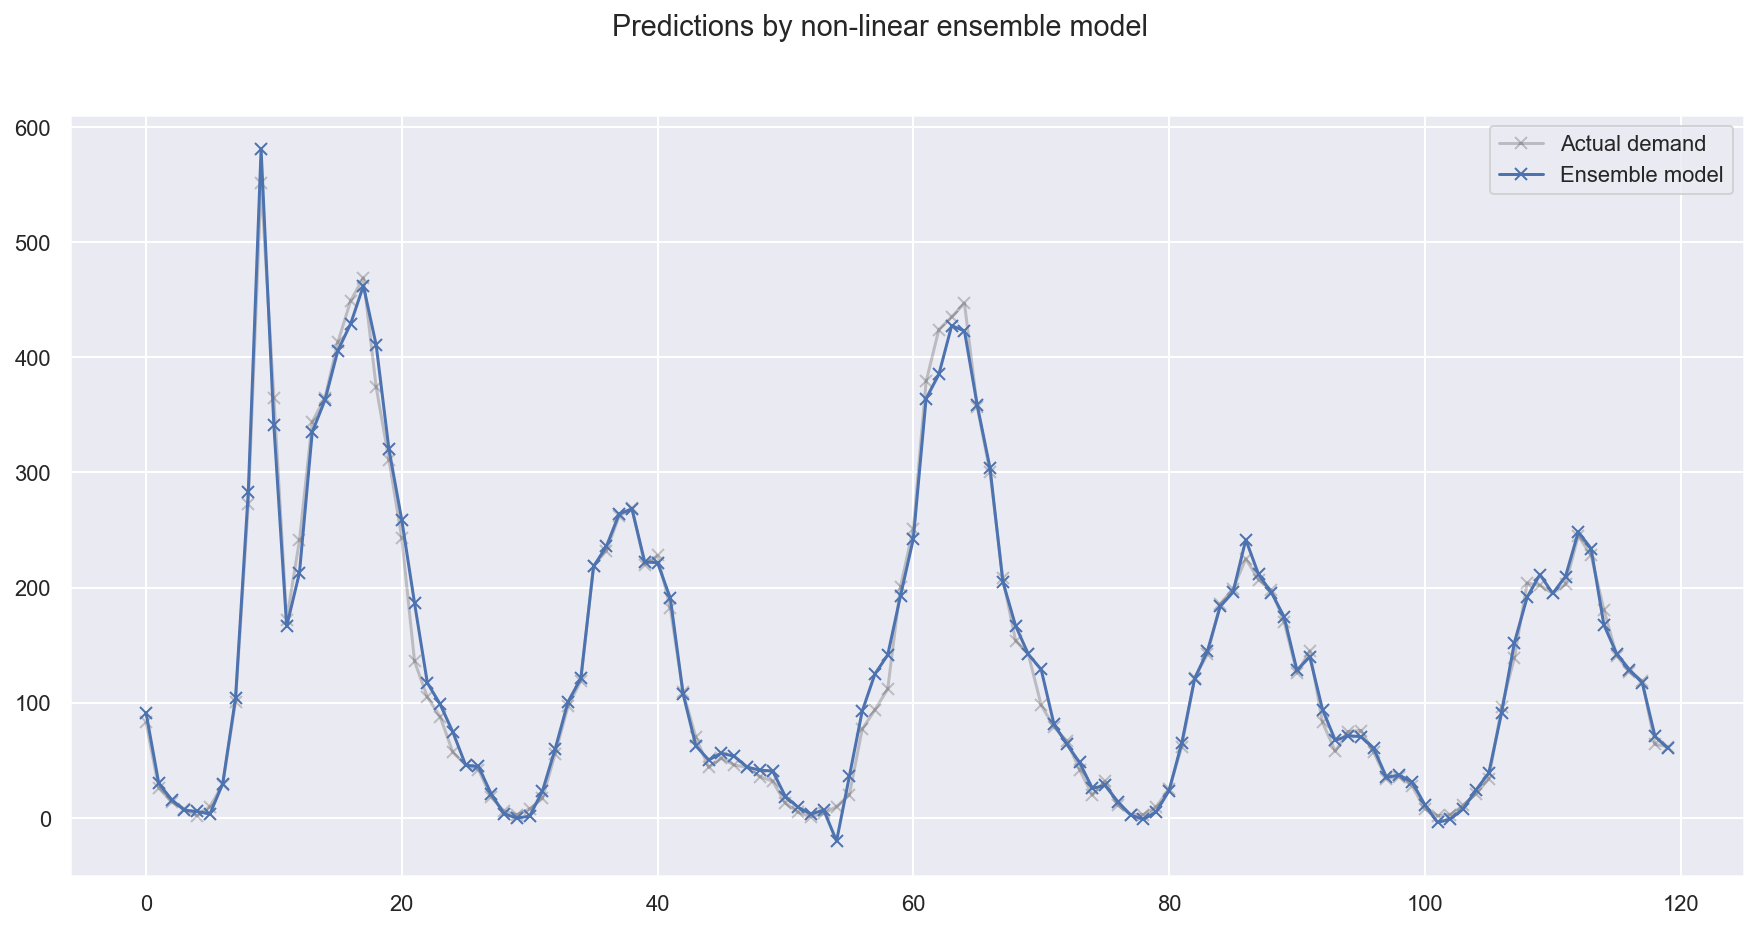

In [81]:
last_hours = slice(-120, None)
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Predictions by non-linear ensemble model")
ax.plot(
    test_y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    final_predictions[last_hours],
    "x-",
    label="Ensemble model",
)
_ = ax.legend()

## Final: Save the pipeline

We are ready to save the pipeline, this can be done again by the library joblib.

In [85]:
joblib.dump(final_model, "models/OSCAR_model.joblib");

Congratulations, be proud of yourself because this is done!

<p align="center">
    <img src="https://media.tenor.com/NgGtOYw27q8AAAAd/looney-tunes-thats-all-folks.gif">
</p>